In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import plot_tree
plt.rcParams["axes.unicode_minus"]=False

# 목표변수 / 설명변수 / 컨셉

- 목표변수 : PM10(미세먼지 정도)
- 설명변수 : PM10 이외 모든 데이터
    - 파생변수 : 풍향, 강수여부, 계절
- 컨셉 : 국내 정책이 올바른 방향으로 정해졌는가? 정확히 인자에 대한 분석을 하고 있는가?
- 온실 속 화초처럼 잘 정제된 데이터만 가지고 연습을 했다면 이젠 실전이다. 예측률 50% 이하에서 허덕이는 초보 분석가...

# 데이터 전처리

In [4]:
data=pd.read_csv("./AIR_POLLUTION.csv", parse_dates=['MeasDate'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   MeasDate   366 non-null    datetime64[ns]
 1   PM10       365 non-null    float64       
 2   O3         365 non-null    float64       
 3   NO2        365 non-null    float64       
 4   CO         311 non-null    float64       
 5   SO2        365 non-null    float64       
 6   TEMP       366 non-null    float64       
 7   RAIN       366 non-null    float64       
 8   WIND       366 non-null    float64       
 9   WIND_DIR   366 non-null    int64         
 10  HUMIDITY   366 non-null    float64       
 11  ATM_PRESS  366 non-null    float64       
 12  SNOW       366 non-null    float64       
 13  CLOUD      366 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 40.2 KB


In [6]:
print(data.shape)

(366, 14)


## 데이터 확인

### 데이터 중복 확인

In [7]:
data.duplicated().sum()

0

- 중복이 없음을 확인함

### 데이터 결측치 확인

In [8]:
data.isnull().sum()

#nullindex=data.loc[data.PM10.isnull()]


MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

#### 목표변수인 PM10 결측
- 행번호 확인 후 삭제

In [9]:
idx=data[data['PM10'].isnull()].index
print("PM10이 결측인 인덱스: {}\n확인 후 삭제".format(idx))
data=data.drop(idx)

PM10이 결측인 인덱스: Int64Index([328], dtype='int64')
확인 후 삭제


In [10]:
data.isnull().sum()

MeasDate      0
PM10          0
O3            0
NO2           0
CO           54
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

In [11]:
data[data['PM10']>50]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
16,2019-07-17,66.0,0.035,0.029,0.6,0.003,25.54,0.70,1.18,189,74.5,1001.3,0.0,8.75
17,2019-07-18,70.0,0.056,0.035,0.7,0.004,27.04,0.00,1.12,192,64.9,998.9,0.0,6.79
120,2019-10-29,83.0,0.021,0.023,0.4,0.003,13.05,0.25,2.40,286,62.1,1004.9,0.0,2.21
122,2019-10-31,72.0,0.022,0.041,0.6,0.004,14.23,0.00,2.21,138,72.8,1010.3,0.0,4.38
123,2019-11-01,89.0,0.027,0.037,0.6,0.003,15.30,0.00,1.80,256,60.0,1011.1,0.0,2.42
124,2019-11-02,67.0,0.010,0.059,0.8,0.005,13.35,0.00,1.42,160,57.2,1010.2,0.0,7.04
140,2019-11-18,62.0,0.023,0.016,0.4,0.002,5.53,5.93,3.65,280,62.8,1007.6,0.0,7.08
161,2019-12-09,61.0,0.003,0.050,0.9,0.004,2.53,0.00,2.45,71,56.6,1012.9,0.0,8.04
162,2019-12-10,101.0,0.010,0.055,1.0,0.004,8.12,0.85,1.22,148,80.6,1008.7,0.0,8.83
163,2019-12-11,73.0,0.021,0.032,0.7,0.004,6.95,0.10,3.26,230,64.5,1006.6,0.0,5.58


In [12]:
print(data.shape)

(365, 14)


- PM10의 결측이 행을 삭제했다.

#### 설명변수 결측치
- CO의 분포를 확인

CO의 평균 값 : 0.5170418006430879


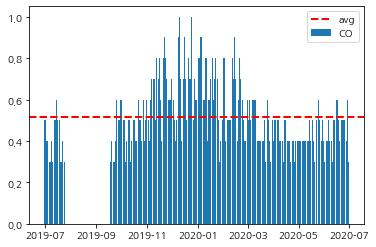

In [13]:
co_mean=data.describe()['CO'][1]
print('CO의 평균 값 : {}'.format(co_mean))

plt.bar(data['MeasDate'], data['CO'],)
plt.axhline(y=co_mean,linewidth=2, color='r', linestyle='--')
plt.legend(['avg' , 'CO'])

https://cleanair.seoul.go.kr/board/download?fileType=FILE&bbsSeq=1025
에서 2019년 8월 평균 CO 가져오기

- 0.4

             PM10          O3         NO2          CO         SO2        TEMP  \
count  365.000000  365.000000  365.000000  365.000000  365.000000  365.000000   
mean    33.421918    0.023600    0.026814    0.499726    0.003033   13.853890   
std     15.937983    0.011896    0.010271    0.147040    0.000632    9.841944   
min      5.000000    0.002000    0.008000    0.300000    0.002000   -7.950000   
25%     22.000000    0.014000    0.019000    0.400000    0.003000    5.480000   
50%     31.000000    0.023000    0.025000    0.500000    0.003000   13.870000   
75%     42.000000    0.032000    0.034000    0.600000    0.003000   23.100000   
max    101.000000    0.062000    0.059000    1.000000    0.005000   31.720000   

             RAIN        WIND    WIND_DIR    HUMIDITY    ATM_PRESS  \
count  365.000000  365.000000  365.000000  365.000000   365.000000   
mean     0.378712    2.223589  209.320548   60.232055  1005.866575   
std      1.122268    0.723421   70.788136   14.504766     8.

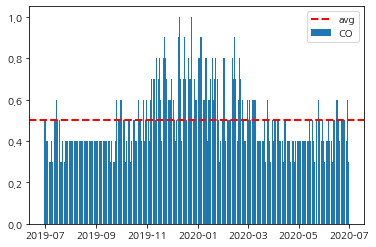

In [14]:
data.fillna(0.4, inplace=True)
print(data.describe())
# CO를 채워주고 평균은 0.499로 줄었다
co_mean=data.describe()['CO'][1]
print('CO의 평균 값 : {}'.format(co_mean))

plt.bar(data['MeasDate'], data['CO'],)
plt.axhline(y=co_mean,linewidth=2, color='r', linestyle='--')
plt.legend(['avg' , 'CO'])

In [15]:
original_data=data
print(original_data)

      MeasDate  PM10     O3    NO2   CO    SO2   TEMP  RAIN  WIND  WIND_DIR  \
0   2019-07-01  29.0  0.054  0.021  0.5  0.003  24.03  0.00  2.30       249   
1   2019-07-02  26.0  0.053  0.020  0.5  0.003  24.29  0.00  2.26       265   
2   2019-07-03  30.0  0.042  0.023  0.4  0.003  24.18  0.00  1.79       280   
3   2019-07-04  28.0  0.034  0.026  0.4  0.003  25.35  0.00  2.04       263   
4   2019-07-05  29.0  0.045  0.035  0.5  0.003  27.30  0.00  1.45       175   
..         ...   ...    ...    ...  ...    ...    ...   ...   ...       ...   
361 2020-06-26  19.0  0.039  0.016  0.4  0.003  21.66  0.41  3.12       228   
362 2020-06-27  22.0  0.044  0.017  0.4  0.004  23.94  0.00  1.93       217   
363 2020-06-28  27.0  0.044  0.009  0.4  0.003  25.03  0.00  2.35       283   
364 2020-06-29  36.0  0.026  0.028  0.6  0.003  24.06  1.26  2.48       103   
365 2020-06-30   6.0  0.039  0.009  0.3  0.002  20.60  5.60  4.00        50   

     HUMIDITY  ATM_PRESS  SNOW  CLOUD  
0        63

In [16]:
original_data.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

### 이상치 확인

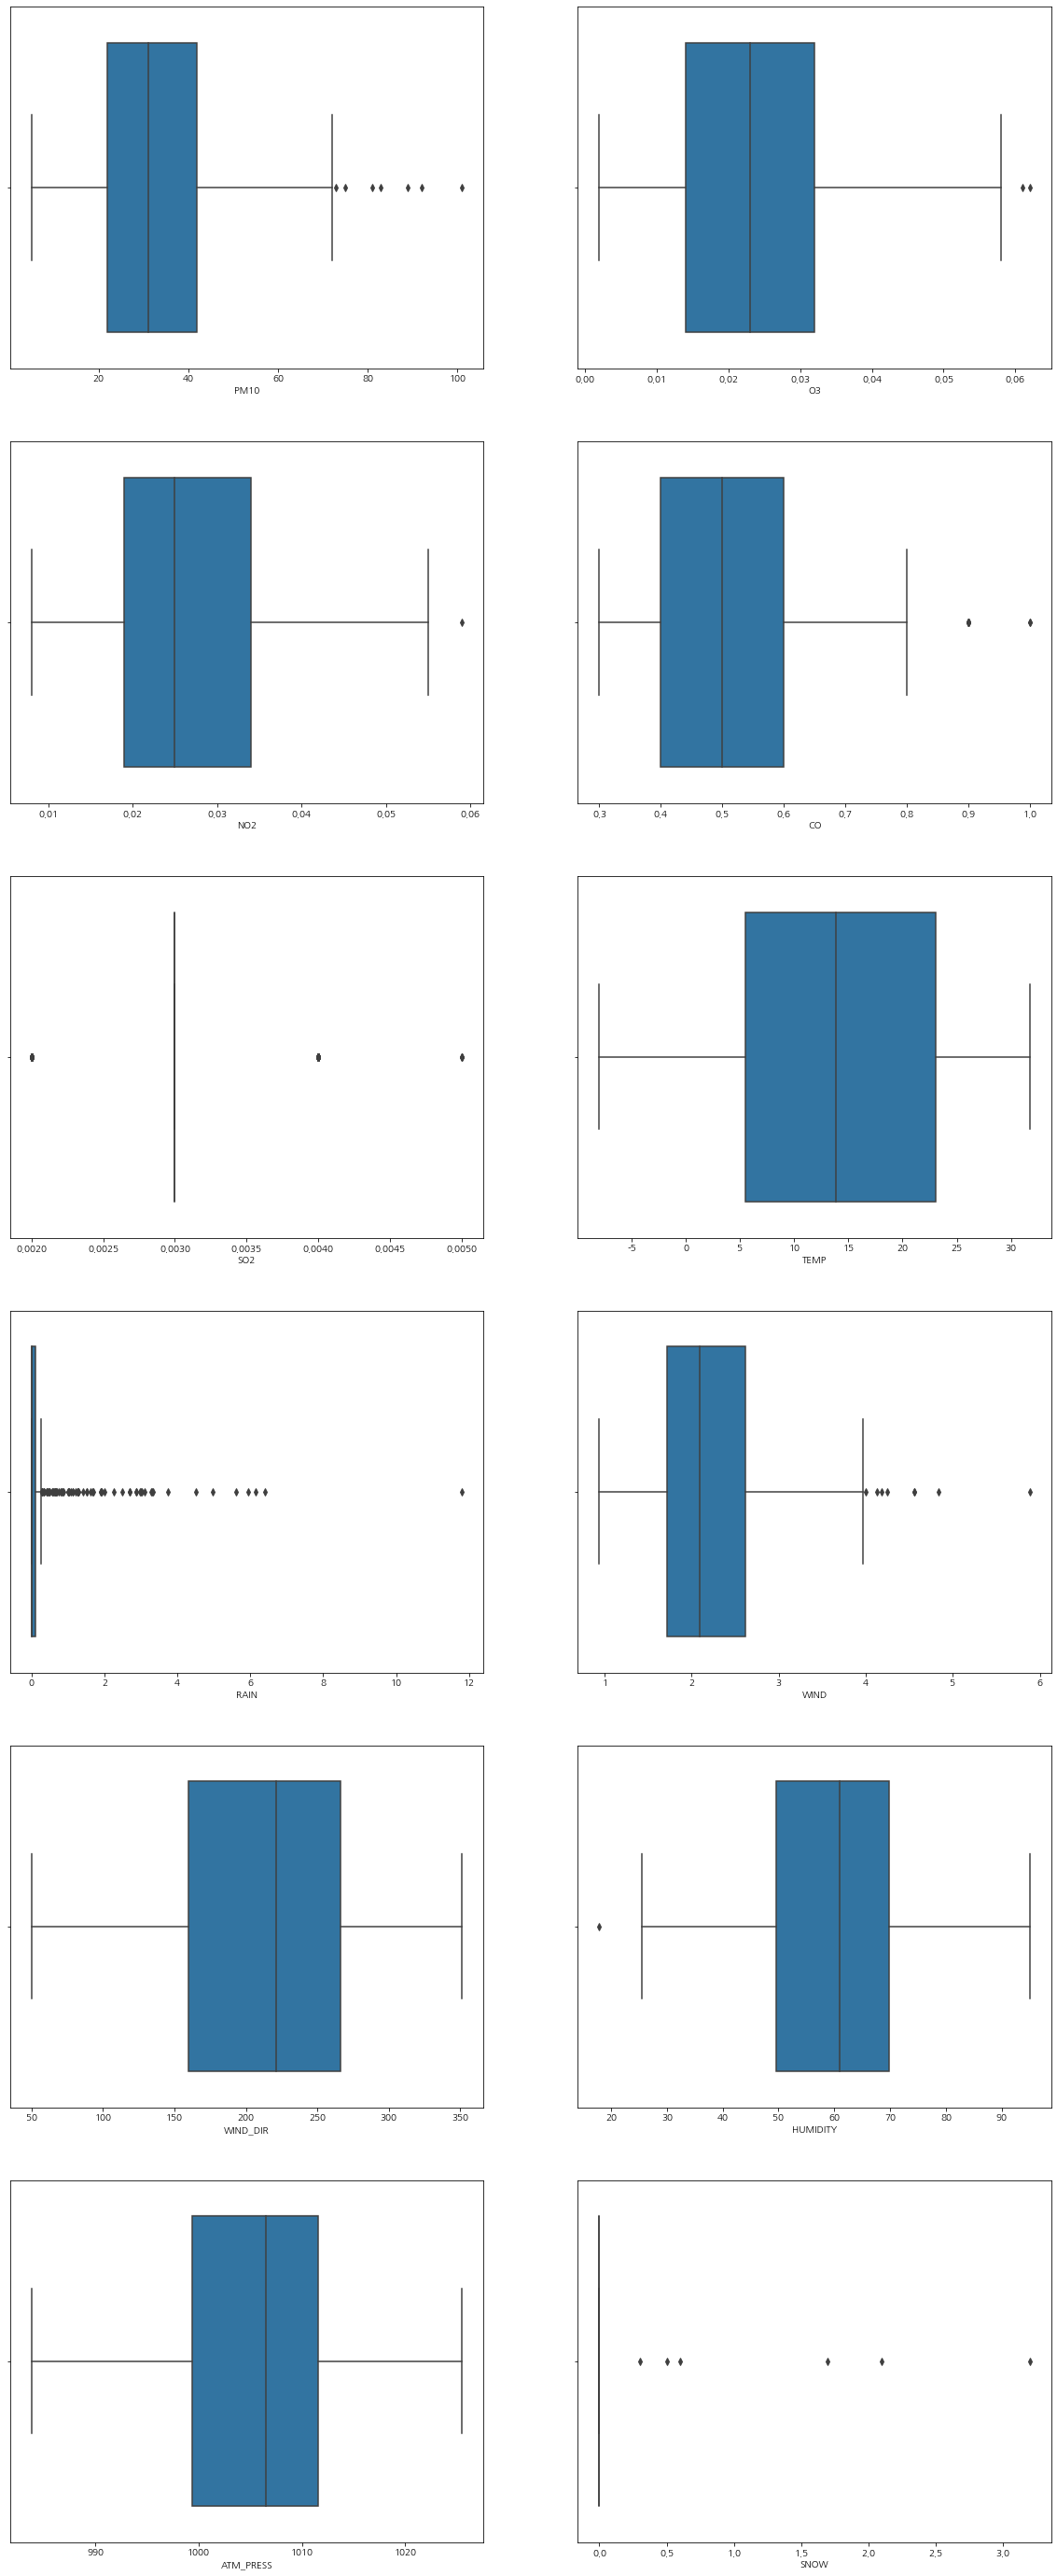

In [17]:
fig, ax = plt.subplots(figsize=(20, 50), nrows=6, ncols=2)
k=1
for i in range(6):
    for j in range(2):
        sns.boxplot(x=data.iloc[:,k], orient='h', ax=ax[i,j])
        k+=1
        

C:\Users\h\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='CLOUD'>

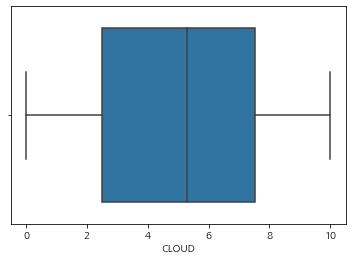

In [18]:
sns.boxplot(x=data.iloc[:,13], orient='v')

- 박스 플롯 상 이상치가 관측되었지만, 분석자는 대기 환경에 대해 전문가가 아니므로 이상치 조정이 가져올 결과를 확신할 수 없으므로 수정하지 않는다.

## 파생변수 생성
- 효과적인 분석을 위해 파생변수를 생성하고, 필요하다면 범주형 데이터를 더미화한다.

### 날짜 - 사계절 치환(범주형)

- **4계절의 구분 (출처: 국립기상과학원 보도자료 2021.4.27**
    - 봄 3월 1일 - spring
    - 여름 5월 31일 - summer
    - 가을 9월 26일 - fall
    - 겨울 12월 4일 - winter
    

In [19]:
# 계절 반환 함수
def seasons(date):
    m=date.month*100
    d=date.day
    md=m+d
    
    if ((md >= 301) and (md <= 531)):
            s = 'spring'
    elif ((md > 531) and (md < 926)):
        s = 'summer'
    elif ((md >= 926) and (md <= 1204)):
        s = 'fall'
    elif ((md > 1204) or (md <= 229)):
        s = 'winter'
    return s


In [20]:
# SEASON 파생변수 생성
data['SEASON']=data['MeasDate'].apply(seasons)

print(data[['MeasDate', 'SEASON']].head())

    MeasDate  SEASON
0 2019-07-01  summer
1 2019-07-02  summer
2 2019-07-03  summer
3 2019-07-04  summer
4 2019-07-05  summer


- 파생변수 사계절 항목을 추가했다

### 눈/비 - 강수여부 치환(범주형)
- 보편적으로 강수여부는 미세먼지 세정 효과가 있다는 사실을 알고 있다.
    - 비 혹은 눈이 온 날을 1로, 전혀 오지 않은 날을 0으로 갖는 파생변수 PRECIPITATION(강수)를 만든다

In [21]:
data['PRECIPITATION']= ['YES' if (s > 0 or r> 0) else 'NO' for s, r in zip(data['SNOW'], data['RAIN'])]
print(data['PRECIPITATION'])
#기존의 눈/비와 관련한 컬럼을 삭제한다
data.drop('SNOW',axis=1, inplace =True)

0       NO
1       NO
2       NO
3       NO
4       NO
      ... 
361    YES
362     NO
363     NO
364    YES
365    YES
Name: PRECIPITATION, Length: 365, dtype: object


In [22]:
data.drop('RAIN', axis=1, inplace=True)

In [23]:
data

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,SEASON,PRECIPITATION
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,2.30,249,63.2,995.1,5.70,summer,NO
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,2.26,265,63.2,998.6,3.83,summer,NO
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,1.79,280,65.3,998.3,6.29,summer,NO
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,2.04,263,58.6,996.6,2.54,summer,NO
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,1.45,175,45.5,993.5,3.92,summer,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,3.12,228,84.0,996.0,8.73,summer,YES
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,1.93,217,69.8,995.8,6.21,summer,NO
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,2.35,283,71.3,994.7,2.63,summer,NO
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,24.06,2.48,103,75.5,992.9,7.58,summer,YES


### 풍향각 - 8방위 치환(범주형)

- 풍향은 북쪽 0' 동쪽 90' 같이 북쪽부터 시계 방향으로 359'까지의 각도가 사용된다.
- [북북, 북동, 동동, 남동, 남남, 남서, 서서, 북서] 로 8가지 방위로 구분하도록 한다.

In [24]:
# 바람 8방위 반환 함수
def direction(angle):
    # 8가지 방위
    windirection=['북북', '북동', '동동', '남동', '남남', '남서', '서서', '북서'] 
    if round(angle/45) == 8:
        return windirection[0]
    return windirection[round(angle/45)]

In [25]:
data['CARDINAL_POINTS']=data['WIND_DIR'].apply(direction)
print(data['CARDINAL_POINTS'])
# 기존의 풍향 컬럼은 삭제해준다.
data.drop('WIND_DIR',axis=1, inplace =True)

0      서서
1      서서
2      서서
3      서서
4      남남
       ..
361    남서
362    남서
363    서서
364    동동
365    북동
Name: CARDINAL_POINTS, Length: 365, dtype: object


In [26]:
data['CARDINAL_POINTS']

0      서서
1      서서
2      서서
3      서서
4      남남
       ..
361    남서
362    남서
363    서서
364    동동
365    북동
Name: CARDINAL_POINTS, Length: 365, dtype: object

- 파생변수 바람 8방위가 추가되었다

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 365
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MeasDate         365 non-null    datetime64[ns]
 1   PM10             365 non-null    float64       
 2   O3               365 non-null    float64       
 3   NO2              365 non-null    float64       
 4   CO               365 non-null    float64       
 5   SO2              365 non-null    float64       
 6   TEMP             365 non-null    float64       
 7   WIND             365 non-null    float64       
 8   HUMIDITY         365 non-null    float64       
 9   ATM_PRESS        365 non-null    float64       
 10  CLOUD            365 non-null    float64       
 11  SEASON           365 non-null    object        
 12  PRECIPITATION    365 non-null    object        
 13  CARDINAL_POINTS  365 non-null    object        
dtypes: datetime64[ns](1), float64(10), object(

# 그래프 분석

## 목표변수의 분포 확인

(array([31., 84., 86., 79., 46., 18., 14.,  3.,  2.,  2.]),
 array([  5. ,  14.6,  24.2,  33.8,  43.4,  53. ,  62.6,  72.2,  81.8,
         91.4, 101. ]),
 <BarContainer object of 10 artists>)

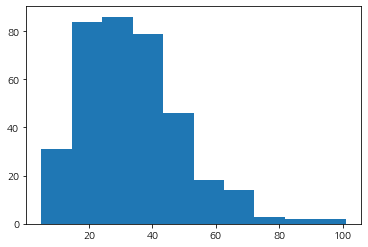

In [29]:
plt.hist(data['PM10'])

PM10의 평균 값 : 33.42191780821918


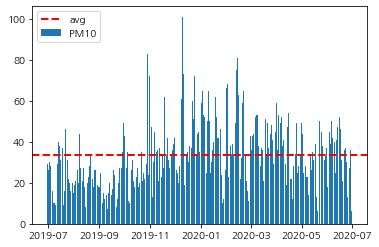

In [30]:
pm10_mean=data['PM10'].describe()[1]
print('PM10의 평균 값 : {}'.format(pm10_mean))

plt.bar(data['MeasDate'], data['PM10'],)
plt.axhline(y=pm10_mean,linewidth=2, color='r', linestyle='--')
plt.legend(['avg' , 'PM10'])

## 목표변수와 각 설명변수 간 상관계수와 Scatter plot

In [31]:
## 목표변수와 설명변수의 corr
Corr=data.corr().round(3)
Corr

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
PM10,1.000,-0.052,0.396,0.613,0.429,-0.310,-0.100,-0.150,0.253,-0.172
O3,-0.052,1.000,-0.592,-0.519,-0.234,0.516,0.165,-0.038,-0.534,-0.119
NO2,0.396,-0.592,1.000,0.791,0.563,-0.237,-0.537,-0.066,0.420,0.017
CO,0.613,-0.519,0.791,1.000,0.594,-0.473,-0.339,-0.034,0.476,-0.033
SO2,0.429,-0.234,0.563,0.594,1.000,-0.274,-0.253,-0.302,0.334,-0.191
TEMP,-0.310,0.516,-0.237,-0.473,-0.274,1.000,-0.216,0.404,-0.792,0.342
WIND,-0.100,0.165,-0.537,-0.339,-0.253,-0.216,1.000,-0.084,-0.054,0.017
HUMIDITY,-0.150,-0.038,-0.066,-0.034,-0.302,0.404,-0.084,1.000,-0.510,0.628
ATM_PRESS,0.253,-0.534,0.420,0.476,0.334,-0.792,-0.054,-0.510,1.000,-0.430
CLOUD,-0.172,-0.119,0.017,-0.033,-0.191,0.342,0.017,0.628,-0.430,1.000


In [32]:
abs(Corr['PM10']).sort_values(ascending=False)

PM10         1.000
CO           0.613
SO2          0.429
NO2          0.396
TEMP         0.310
ATM_PRESS    0.253
CLOUD        0.172
HUMIDITY     0.150
WIND         0.100
O3           0.052
Name: PM10, dtype: float64

- 목표변수인 PM10과 설명변수 간의 상관관계를 보았다. CO와 SO2, NO2 순으로 상관계수가 크다.

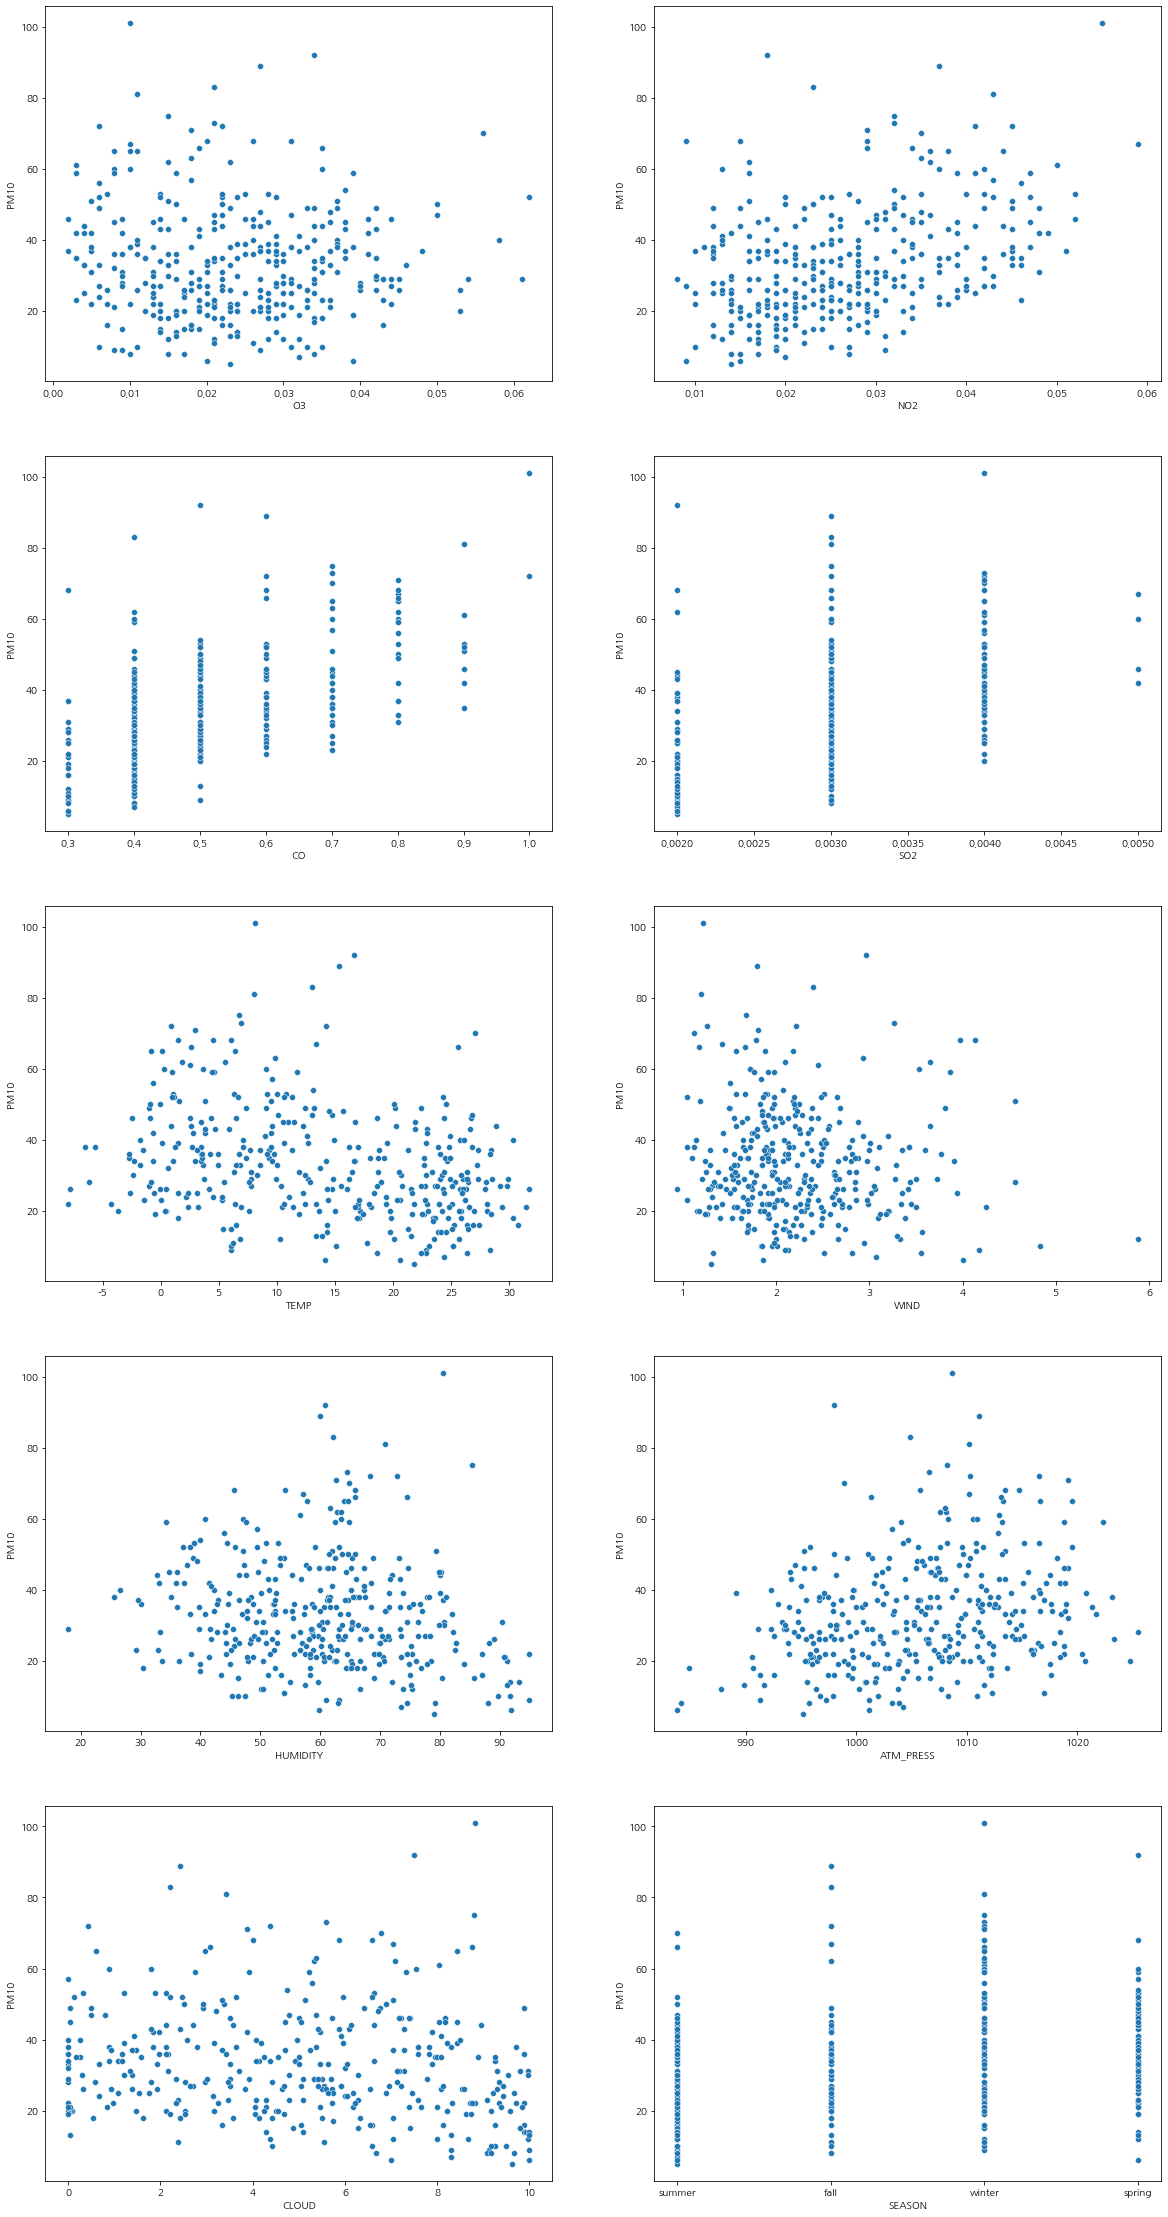

In [33]:
fig, ax = plt.subplots(figsize=(20,40), nrows=5,ncols=2)
xs=data.columns

k=2
for i in range(5):
    for j in range(2):
        sns.scatterplot(x=xs[k], y='PM10', data=data,legend='full', ax=ax[i,j])
        k+=1

<AxesSubplot:xlabel='CLOUD', ylabel='PM10'>

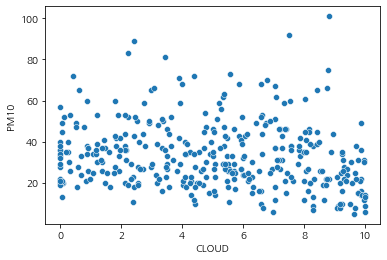

In [34]:
sns.scatterplot(x='CLOUD', y='PM10', data=data,legend='full')

## 설명변수간 상관관계

<AxesSubplot:>

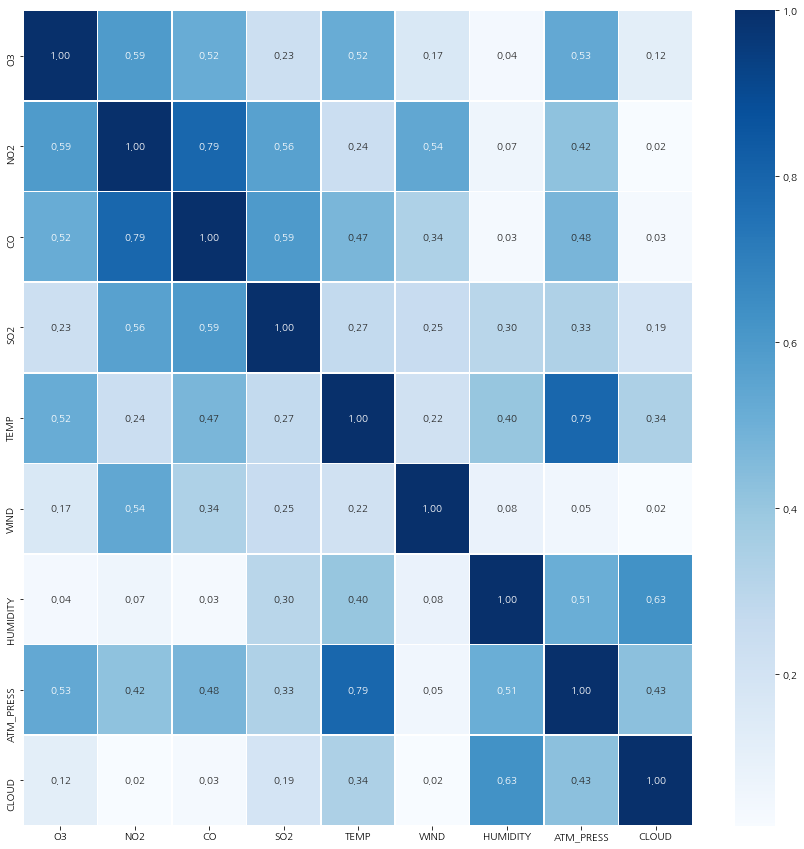

In [35]:
plt.figure(figsize=(15,15))
df_raw_x=data.drop('PM10', axis=1)
sns.heatmap(data = abs(df_raw_x.corr()), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

- heapmap을 통해 설명변수 간 상관관계를 알 수 있다.
- 색이 진할수록 높은 상관관계를 보인다

In [36]:
corr=df_raw_x.corr().round(3)
corr

,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
O3,1.000,-0.592,-0.519,-0.234,0.516,0.165,-0.038,-0.534,-0.119
NO2,-0.592,1.000,0.791,0.563,-0.237,-0.537,-0.066,0.420,0.017
CO,-0.519,0.791,1.000,0.594,-0.473,-0.339,-0.034,0.476,-0.033
SO2,-0.234,0.563,0.594,1.000,-0.274,-0.253,-0.302,0.334,-0.191
TEMP,0.516,-0.237,-0.473,-0.274,1.000,-0.216,0.404,-0.792,0.342
WIND,0.165,-0.537,-0.339,-0.253,-0.216,1.000,-0.084,-0.054,0.017
HUMIDITY,-0.038,-0.066,-0.034,-0.302,0.404,-0.084,1.000,-0.510,0.628
ATM_PRESS,-0.534,0.420,0.476,0.334,-0.792,-0.054,-0.510,1.000,-0.430
CLOUD,-0.119,0.017,-0.033,-0.191,0.342,0.017,0.628,-0.430,1.000


In [37]:
absedcorr=abs(corr)
corr_count=0
for i in range(1, len(absedcorr)):
    for j in range(i):
        if absedcorr.iloc[j][i]>0.7:
            print("Corr btw {} and {} : {}".format(corr.index[j], corr.index[i],corr.iloc[j][i] ))
            corr_count+=1
print("\n\n****0.7 이상의 상관계수를 갖는 변수 쌍의 개수**** \n\t\t\t{}쌍".format(corr_count))

Corr btw NO2 and CO : 0.791
Corr btw TEMP and ATM_PRESS : -0.792


****0.7 이상의 상관계수를 갖는 변수 쌍의 개수**** 
			2쌍


- 변수간 상관관계를 계산한 결과, 높은 상관관계(일반적으로 절대값 0.7 이상)를 보이는 두 쌍의 변수들을 뽑을 수 있었다.
- NO2와 CO는 0.791 -> 양의 상관관계
- TEMP와 ATM_PRESS는 -0.792 -> 음의 상관관계

<AxesSubplot:title={'center':'ATM_PRESS와 TEMP'}, xlabel='ATM_PRESS', ylabel='TEMP'>

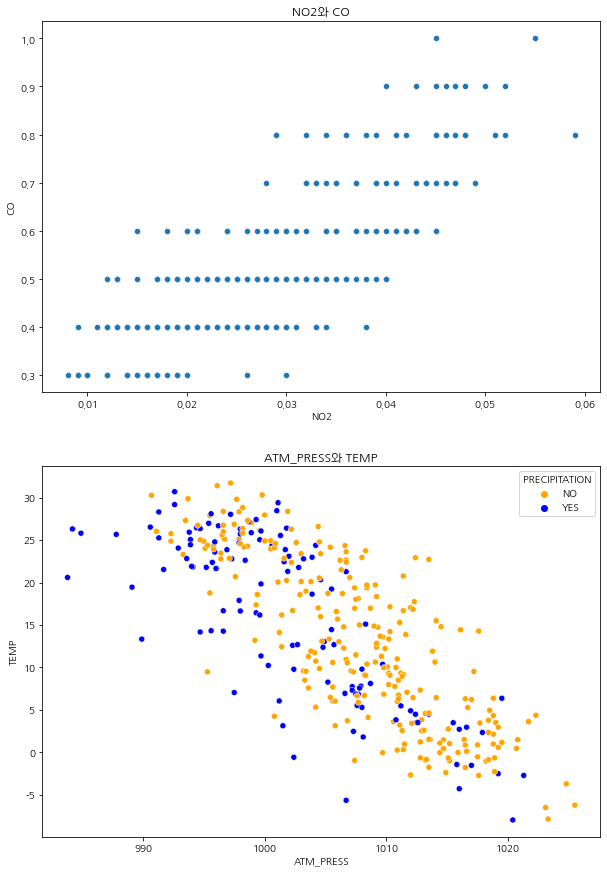

In [38]:
fig, ax = plt.subplots(figsize=(10,15), nrows=2)
ax[0].set_title('NO2와 CO')
ax[1].set_title('ATM_PRESS와 TEMP')
color_dict=dict({'YES': 'blue', 'NO': 'orange'})

sns.scatterplot(x="NO2", y="CO",data=df_raw_x, legend='full', ax=ax[0])

ax[0]=plt.grid()

ax[1]=plt.grid()
sns.scatterplot(x="ATM_PRESS", y="TEMP", hue="PRECIPITATION",
              data=df_raw_x,palette=color_dict,  legend='full', ax=ax[1])

- NO2와 CO, TEMP와 ATM_PRESS의 산점도를 보면 위와 같다.
- 상식적으로 기압과 온도의 관계는 반비례 관계이다. 
- NO2와 CO, TEMP와 ATM_PRESS를 각각 묶어 새로운 파생변수로 만들 수 있지 않을까?
- 기온이 기압을 변하게 한다. 기온이 높으면 상대적으로 공기의 무게가 가벼워져서 기압이 낮아지게 됨
- TEMP_PRESS 파생변수는 그 값을 TEMP로 갖는다. (기존의 TEMP와 PRESS는 삭제한다)

In [39]:
data['TEMP_PRESS'] = data['TEMP']


print(data)

      MeasDate  PM10     O3    NO2   CO    SO2   TEMP  WIND  HUMIDITY  \
0   2019-07-01  29.0  0.054  0.021  0.5  0.003  24.03  2.30      63.2   
1   2019-07-02  26.0  0.053  0.020  0.5  0.003  24.29  2.26      63.2   
2   2019-07-03  30.0  0.042  0.023  0.4  0.003  24.18  1.79      65.3   
3   2019-07-04  28.0  0.034  0.026  0.4  0.003  25.35  2.04      58.6   
4   2019-07-05  29.0  0.045  0.035  0.5  0.003  27.30  1.45      45.5   
..         ...   ...    ...    ...  ...    ...    ...   ...       ...   
361 2020-06-26  19.0  0.039  0.016  0.4  0.003  21.66  3.12      84.0   
362 2020-06-27  22.0  0.044  0.017  0.4  0.004  23.94  1.93      69.8   
363 2020-06-28  27.0  0.044  0.009  0.4  0.003  25.03  2.35      71.3   
364 2020-06-29  36.0  0.026  0.028  0.6  0.003  24.06  2.48      75.5   
365 2020-06-30   6.0  0.039  0.009  0.3  0.002  20.60  4.00      92.0   

     ATM_PRESS  CLOUD  SEASON PRECIPITATION CARDINAL_POINTS  TEMP_PRESS  
0        995.1   5.70  summer            NO      

In [40]:
data.drop(['TEMP', 'ATM_PRESS'], axis=1, inplace=True)
print(data)

      MeasDate  PM10     O3    NO2   CO    SO2  WIND  HUMIDITY  CLOUD  SEASON  \
0   2019-07-01  29.0  0.054  0.021  0.5  0.003  2.30      63.2   5.70  summer   
1   2019-07-02  26.0  0.053  0.020  0.5  0.003  2.26      63.2   3.83  summer   
2   2019-07-03  30.0  0.042  0.023  0.4  0.003  1.79      65.3   6.29  summer   
3   2019-07-04  28.0  0.034  0.026  0.4  0.003  2.04      58.6   2.54  summer   
4   2019-07-05  29.0  0.045  0.035  0.5  0.003  1.45      45.5   3.92  summer   
..         ...   ...    ...    ...  ...    ...   ...       ...    ...     ...   
361 2020-06-26  19.0  0.039  0.016  0.4  0.003  3.12      84.0   8.73  summer   
362 2020-06-27  22.0  0.044  0.017  0.4  0.004  1.93      69.8   6.21  summer   
363 2020-06-28  27.0  0.044  0.009  0.4  0.003  2.35      71.3   2.63  summer   
364 2020-06-29  36.0  0.026  0.028  0.6  0.003  2.48      75.5   7.58  summer   
365 2020-06-30   6.0  0.039  0.009  0.3  0.002  4.00      92.0  10.00  summer   

    PRECIPITATION CARDINAL_

## 연월, 계절별, 풍향별 PM10 수치 변화
- 월별, 연도별, 계절별 PM10의 차이

In [41]:
data.groupby(data['SEASON'])['PM10'].mean().sort_values()
month_pm10=data.groupby(pd.PeriodIndex(data['MeasDate'], freq='M'))['PM10'].mean()
df_month_pm10=pd.DataFrame({'PM10 mean by month':month_pm10})

year_pm10=data.groupby(pd.PeriodIndex(data['MeasDate'], freq='Y'))['PM10'].mean()
df_year_pm10=pd.DataFrame({'PM10 mean by year':year_pm10})
print(df_year_pm10)
print(df_month_pm10)

          PM10 mean by year
MeasDate                   
2019              29.092391
2020              37.823204
          PM10 mean by month
MeasDate                    
2019-07            26.322581
2019-08            24.258065
2019-09            20.333333
2019-10            27.451613
2019-11            35.666667
2019-12            40.451613
2020-01            40.967742
2020-02            40.206897
2020-03            41.193548
2020-04            38.900000
2020-05            32.466667
2020-06            33.066667


PM10의 평균 값 : 33.42191780821918


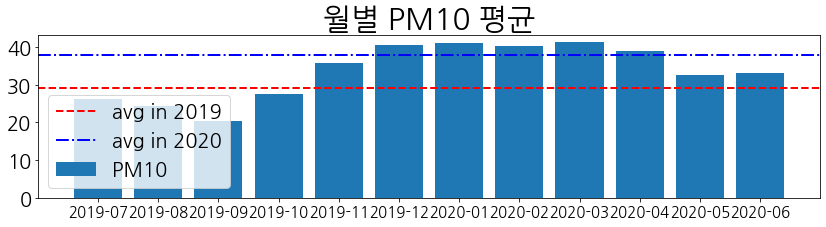

In [42]:
pm10_mean=data['PM10'].describe()[1]
f, ax = plt.subplots(figsize=(14,3)) 

print('PM10의 평균 값 : {}'.format(pm10_mean))

plt.bar(df_month_pm10.index.astype('str'),df_month_pm10['PM10 mean by month'])

plt.axhline(y=year_pm10[0],linewidth=2, color='r', linestyle='--')
plt.axhline(y=year_pm10[1],linewidth=2, color='b', linestyle='-.')
plt.title('월별 PM10 평균',fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.legend(['avg in 2019','avg in 2020' , 'PM10'], fontsize=20)

Text(0.5, 1.0, '계절별 PM10 평균')

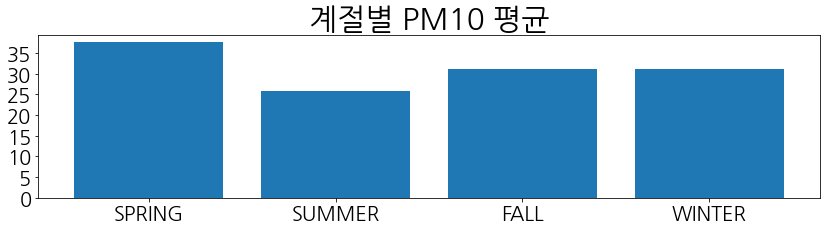

In [43]:
sp=data[data['SEASON']=='spring']['PM10'].mean()
fall=data[data['SEASON']=='fall']['PM10'].mean()

summer=data[data['SEASON']=='summer']['PM10'].mean()
winter=data[data['SEASON']=='fall']['PM10'].mean()
df_season_pm10=pd.DataFrame({'AVG': [sp, summer, fall, winter]}, index=['SPRING', 'SUMMER', 'FALL', 'WINTER'])

f, ax = plt.subplots(figsize=(14,3)) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.bar(df_season_pm10.index.astype('str'),df_season_pm10['AVG'])
plt.title('계절별 PM10 평균',fontsize=30)

## 비/눈이 올 때, 안 올 때 PM10 평균 수치

Text(0.5, 1.0, '비/눈이 오는 날과 오지 않는 날 PM10 평균')

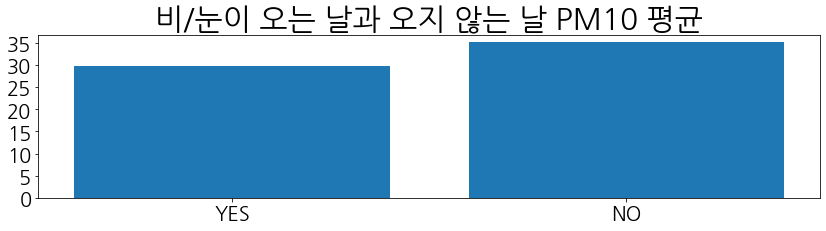

In [48]:
yes=data[data['PRECIPITATION']=='YES']['PM10'].mean()
no=data[data['PRECIPITATION']=='NO']['PM10'].mean()

df_precipitation=pd.DataFrame({'AVG': [yes, no]}, index=['YES', 'NO'])
f, ax = plt.subplots(figsize=(14,3)) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.bar(df_precipitation.index.astype('str'),df_precipitation['AVG'])
plt.title('비/눈이 오는 날과 오지 않는 날 PM10 평균',fontsize=30)

## 풍향에 따른 PM10 평균수치

Text(0.5, 1.0, '풍향별 PM10 평균')

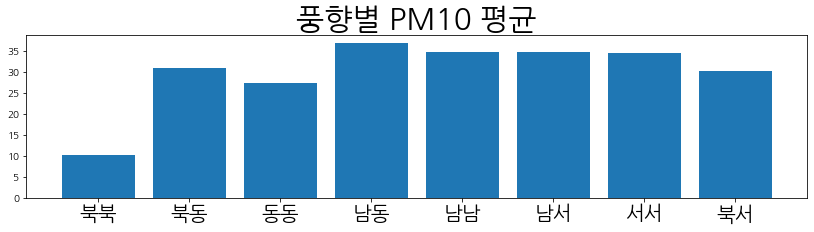

In [49]:


windirection=['북북', '북동', '동동', '남동', '남남', '남서', '서서', '북서'] 
windirection_pm10_mean=list()
for dirc in windirection:
    windirection_pm10_mean.append(data[data['CARDINAL_POINTS']==dirc]['PM10'].mean())
f, ax = plt.subplots(figsize=(14,3)) 

plt.bar(windirection,windirection_pm10_mean)
plt.xticks(fontsize=20)
plt.title('풍향별 PM10 평균',fontsize=30)



- 연월별, 계절별 PM10의 평균을 바플롯으로 시각화했다.
- 봄철 PM10은 상식대로 다른 계절들보다 높은 평균값을 보였다. 겨울-봄의 미세먼지 수치가 다른 계절보다 훨씬 높았다
- 2019년보다 2020년의 PM10 평균이 높았다.
    - 겨울과 봄 PM10 데이터가 포함된 2020년 PM10 수치가 높게 나오는 것이다.

<ipython-input-50-5a1e1812bbca>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(polars.compass, fontsize=15)


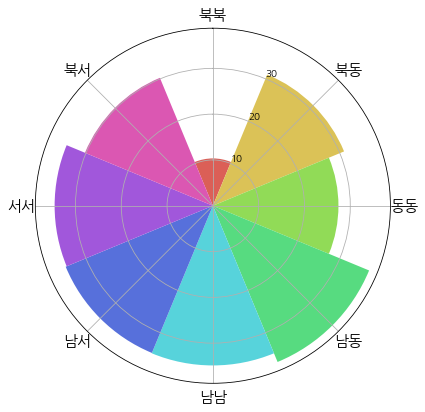

In [50]:
from matplotlib.gridspec import GridSpec
from numpy import pi

polars = pd.DataFrame({
                     'bearing': range(0, 360, 45),
                     'compass': ['북북', '북동', '동동', '남동', '남남', '남서', '서서', '북서']})

polars.index = polars['bearing'] * 2*pi / 360
colors = sns.color_palette('hls',len(polars.compass))
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.bar(x=polars.index, height=windirection_pm10_mean, width=pi/4, color=colors)
ax2.set_xticklabels(polars.compass, fontsize=15)
ax2.set_rgrids([10, 20, 30])

plt.show()

# 통계적 가설 검정 - 인자 검정
## 파생변수 계절에 따른 PM10 데이터의 평균 차이가 있는가?
- 검정 과정

 - 가설 설정
   - 귀무가설 : 두 집단의 평균의 차이는 없다 (귀무가설을 기각함으로써 대립가설을 증명하고자 함)
   - 대립가설 : 두 집단의 평균의 차이는 있다
 - 유의 수준 설정
 - 정규성 검사(각 데이터는 정규성을 따르는가?) -shapiro
 - 등분산성 검사(각 데이터는 같은 분산을 가지는가?) - levene
 - t-test 돌리기

- **Q)** 봄철과 가을철의 미세먼지 데이터 관련하여 모평균에 차이가 있다고 할 수 있는가? (유의수준 alpha=0.05)

**1) 가설 설정**
 - 귀무가설 : 봄철과 가을철의 PM10의 평균의 차이는 없다 
 - 대립가설 : 봄철과 가을철의 PM10의  평균의 차이는 있다 

**2) shapiro 정규성 검사**
- 검정통계량과 p-value를 출력함
 - 정규성 검사의 귀무가설 : 정규분포를 따른다 (정규성 검사에서는 귀무가설을 증명하고자 함)
  - p-value가 0.05보다 작으면 귀무가설 기각됨. 즉 정규분포를 따르지 않음

In [51]:
from scipy.stats import shapiro


sp=data[data['SEASON']=='spring']['PM10']
fall=data[data['SEASON']=='fall']['PM10']
df_spring=pd.DataFrame({'PM10': sp})
df_fall=pd.DataFrame({'PM10': fall})

print(shapiro(df_spring))
print(shapiro(df_fall))

ShapiroResult(statistic=0.9671289920806885, pvalue=0.021164994686841965)
ShapiroResult(statistic=0.8416274189949036, pvalue=3.6768886957361246e-07)


- df_fall 정규성 검사에서 p-value가 약 3.676이므로 0.05보다 크다. 따라서 귀무가설을 지지할 수 있다. 즉, df1은 정규분포를 따른다
- df_spring의 정규성 검사에서 p-value가 약 0.02이므로 0.05보다 작다. 
    - ***따라서 귀무가설을 지지하지 못한다. 하지만, 과제 진행의 편의성을 위해 df_spring이 정규분포를 따른다고 가정하도록 한다.***

**3) df_fall와 df_spring 데이터가 같은 분산을 갖는지 levene 등분산성 검사**
- 검정통계량과 p-value를 출력함
 - 등분산성 검사의 귀무가설 : 두 데이터는 같은 분산을 갖는다 (등분산성 검사에서는 귀무가설을 증명하고자 함)
  - p-value가 0.05보다 작으면 귀무가설 기각됨. 즉 같은 분산을 갖지 않는다고 말할 수 있음

In [52]:
from scipy import stats
import scipy.stats
import statsmodels.api as sm
from scipy.stats import shapiro
stats.levene(df_spring['PM10'] , df_fall['PM10'])

LeveneResult(statistic=0.03559346907064103, pvalue=0.8505980782537453)

- 등분산성 검사에서 p-value가 약 0.85059이므로 0.05보다 크다. 따라서 귀무가설을 지지할 수 있다. 즉, df_spring과 df_fall은 등분산성을 갖는다고 말할 수 있다
 - *참고) 등분산성 검사에서 귀무가설을 기각해야 한다면 다음 t-test에서 같은 분산을 갖지 않는다고 알려줘야 한다*

**4) 2 Sample t-test**

In [53]:
# 2 Sample t-test 수행statistic
t_result=stats.ttest_ind(df_spring, df_fall)

t, p=t_result.statistic, t_result.pvalue
print("****2 Sample t-test****\n검정통계량: {}\nP-value: {}".format(t, p))

****2 Sample t-test****
검정통계량: [2.81769115]
P-value: [0.00545127]


**5) 결론**

- 유의수준 0.05와 p-value 0.0.00545에서 p-value가 더 작으므로 귀무가설은 기각된다.
- 귀무가설 '봄철과 가을철의 PM10의 평균의 차이는 없다'는 지지될 수 없고, 대립가설 '봄철과 가을철의 PM10의 평균의 차이는 있다'는 지지될 수 있다.
- **따라서, 봄철과 가을철의 미세먼지 평균의 차이는 있다고 말할 수 있다**
- 위 그래프에서 본 것처럼 봄, 여름, 가을, 겨울의 PM10 평균의 차이는 유의미함을 우리는 이미 알고 있다. 따라서 봄/가을의 PM10 2 sample t test 이외의 봄/여름, 봄/겨울 등의 t-test는 생략하도록 한다.

## 파생변수 비/눈이 옴, 오지 않음에 따른 PM10 데이터의 평균 차이가 있는가?
**1) 가설 설정**
 - 귀무가설 : 비/눈이 오는 날과 오지 않는 날의 PM10의 평균의 차이는 없다 
 - 대립가설 : 비/눈이 오는 날과 오지 않는 날의  PM10의  평균의 차이는 있다 

**2) 비/눈이 오는 날의 PM10과 와 비/눈이 오지 않는 날의 PM10 데이터 shapiro 정규성 검사**
- 검정통계량과 p-value를 출력함
 - 정규성 검사의 귀무가설 : 정규분포를 따른다 (정규성 검사에서는 귀무가설을 증명하고자 함)
  - p-value가 0.05보다 작으면 귀무가설 기각됨. 즉 정규분포를 따르지 않음

In [54]:
pre_yes=data[data['PRECIPITATION']=='YES']['PM10']
pre_no=data[data['PRECIPITATION']=='NO']['PM10']
df_pre_yes=pd.DataFrame({'PM10': pre_yes})
df_pre_no=pd.DataFrame({'PM10': pre_no})

print(shapiro(df_pre_yes))
print(shapiro(df_pre_no))

ShapiroResult(statistic=0.8846352696418762, pvalue=5.7846261114491426e-08)
ShapiroResult(statistic=0.9638530611991882, pvalue=6.076828867662698e-06)


- df_fall 정규성 검사에서 p-value가 약 0으로 0.05보다 작다. 따라서 귀무가설을 지지할 수 없다. 즉, df1은 정규분포를 따른다고 할 수 없다
- df_spring의 정규성 검사에서 p-value가 약 0으로 0.05보다 작다.
    - ***두 귀무가설을 지지하지 못한다. 하지만, 과제 진행의 편의성을 위해 정규분포를 따른다고 가정하도록 한다.***

**3) 비/눈이 오는 날의 PM10과 와 비/눈이 오지 않는 날의 PM10 데이터가 같은 분산을 갖는지 levene 등분산성 검사**
- 검정통계량과 p-value를 출력함
 - 등분산성 검사의 귀무가설 : 두 데이터는 같은 분산을 갖는다 (등분산성 검사에서는 귀무가설을 증명하고자 함)
  - p-value가 0.05보다 작으면 귀무가설 기각됨. 즉 같은 분산을 갖지 않는다고 말할 수 있음

In [55]:
stats.levene(df_pre_yes['PM10'] , df_pre_no['PM10'])

LeveneResult(statistic=0.8766162422698845, pvalue=0.3497526038794525)

- 등분산성 검사에서 p-value가 약 0.349이므로 0.05보다 크다. 따라서 귀무가설을 지지할 수 있다. 즉, 비/눈이 오는 날의 PM10 데이터와 비/눈이 오지 않는 날의 PM10은 등분산성을 갖는다고 말할 수 있다

**4) 2 Sample t-test**

In [56]:
# 2 Sample t-test 수행statistic
t_result=stats.ttest_ind(df_pre_yes, df_pre_no)

t, p=t_result.statistic, t_result.pvalue
print("****2 Sample t-test****\n검정통계량: {}\nP-value: {}".format(t, p))

****2 Sample t-test****
검정통계량: [-3.0568406]
P-value: [0.00240256]


**5) 결론**

- 유의수준 0.05와 p-value 0.0.0024에서 p-value가 더 작으므로 귀무가설은 기각된다.
- 귀무가설 '비/눈이 오는 날과 오지 않는 날의 PM10의 평균의 차이는 없다'는 지지될 수 없고, 대립가설 ' 비/눈이 오는 날과 오지 않는 날의 PM10의 평균의 차이는 있다는 지지할 수 있다.
- 새롭게 만든 파생변수가 PM10 평균과 유의미한 관계가 있음을 알 수 있다.

# One Hot Encoding
- 모델의 성능을 높이기 위해 카테고리형 데이터(SEASON, PRECIPITATION, CARDINAL_POINTS) 원핫인코딩 실행

In [57]:
df_encoded_raw=pd.get_dummies(data, columns=['SEASON', 'PRECIPITATION', 'CARDINAL_POINTS'])

In [58]:
df_encoded_raw.columns

Index(['MeasDate', 'PM10', 'O3', 'NO2', 'CO', 'SO2', 'WIND', 'HUMIDITY',
       'CLOUD', 'TEMP_PRESS', 'SEASON_fall', 'SEASON_spring', 'SEASON_summer',
       'SEASON_winter', 'PRECIPITATION_NO', 'PRECIPITATION_YES',
       'CARDINAL_POINTS_남남', 'CARDINAL_POINTS_남동', 'CARDINAL_POINTS_남서',
       'CARDINAL_POINTS_동동', 'CARDINAL_POINTS_북동', 'CARDINAL_POINTS_북북',
       'CARDINAL_POINTS_북서', 'CARDINAL_POINTS_서서'],
      dtype='object')

In [59]:
data

,MeasDate,PM10,O3,NO2,CO,SO2,WIND,HUMIDITY,CLOUD,SEASON,PRECIPITATION,CARDINAL_POINTS,TEMP_PRESS
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,2.30,63.2,5.70,summer,NO,서서,24.03
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,2.26,63.2,3.83,summer,NO,서서,24.29
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,1.79,65.3,6.29,summer,NO,서서,24.18
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,2.04,58.6,2.54,summer,NO,서서,25.35
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,1.45,45.5,3.92,summer,NO,남남,27.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,3.12,84.0,8.73,summer,YES,남서,21.66
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,1.93,69.8,6.21,summer,NO,남서,23.94
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,2.35,71.3,2.63,summer,NO,서서,25.03
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,2.48,75.5,7.58,summer,YES,동동,24.06


# 다중선형회귀

- 설명변수 간의 다중공선성을 해결해보도록 한다

## 카테고리형 변수 포함

In [60]:
reg_model_category=smf.ols(formula= "PM10~O3+NO2+CO+SO2+HUMIDITY+CLOUD+TEMP_PRESS+C(PRECIPITATION)+C(CARDINAL_POINTS)+C(SEASON)", data=data)
reg_result=reg_model_category.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     26.61
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.71e-54
Time:                        00:31:58   Log-Likelihood:                -1369.4
No. Observations:                 365   AIC:                             2777.
Df Residuals:                     346   BIC:                             2851.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## 카테고리형 변수를 제외한 기본 모델

In [70]:
original_data.drop('CARDINAL_POINTS',axis=1, inplace=True)
original_data.drop('PRECIPITATION', axis=1,inplace=True)
original_data.drop('SEASON',axis=1, inplace=True)

In [72]:
original_data

,MeasDate,PM10,O3,NO2,CO,SO2,WIND,HUMIDITY,CLOUD,TEMP_PRESS
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,2.30,63.2,5.70,24.03
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,2.26,63.2,3.83,24.29
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,1.79,65.3,6.29,24.18
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,2.04,58.6,2.54,25.35
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,1.45,45.5,3.92,27.30
...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,3.12,84.0,8.73,21.66
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,1.93,69.8,6.21,23.94
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,2.35,71.3,2.63,25.03
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,2.48,75.5,7.58,24.06


In [89]:
reg_model=smf.ols(formula= "PM10~O3+NO2+CO+WIND+SO2+HUMIDITY+CLOUD+TEMP_PRESS", data=original_data)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     45.03
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.15e-49
Time:                        00:58:41   Log-Likelihood:                -1400.4
No. Observations:                 365   AIC:                             2819.
Df Residuals:                     356   BIC:                             2854.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.3046      6.782     -3.731      0.0

- **회귀계수에 대한 가설들**
    - 귀무가설 : 회귀계수는 0이다(설명력이 없다)
    - 대립가설 : 회귀계수는 0이 아니다(설명력이 있다)


- 데이터는 정규성을 가진다 (Omnibus)
- p value 0.05 작은 변수들은 회귀모델로서 유의하다는 뜻이다. 
- 잔차 간 독립성을 보여주는 더빈왓슨값 : 2에 가까울수록 독립적이고 0에 가까울수록 양의 상관관계, 4에 가까울 수록 음의 상관관계
- 분석자료수는 365 / 잔차자유도는 345 / 모델 자유도는 19
    - $345+19+1=365$.

- 알스퀘어는 0.503으로 설명 정도가 다소 낮은 모델이 결과로 나왔다 
    - 1에 가까울수록 목표변수를 잘 설명한다는 뜻

In [90]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
#df_draw_x=original_data.drop("PM10", axis=1) # 목표변수는 뺴준다
# 상수항 추가하기
df_draw_x=original_data.drop(['MeasDate','PM10'], axis=1) #목표변수와 쓰지 않는 변수를 빼준다. 
df_draw_x_const=add_constant(df_draw_x)
print(df_draw_x_const)

     const     O3    NO2   CO    SO2  WIND  HUMIDITY  CLOUD  TEMP_PRESS
0      1.0  0.054  0.021  0.5  0.003  2.30      63.2   5.70       24.03
1      1.0  0.053  0.020  0.5  0.003  2.26      63.2   3.83       24.29
2      1.0  0.042  0.023  0.4  0.003  1.79      65.3   6.29       24.18
3      1.0  0.034  0.026  0.4  0.003  2.04      58.6   2.54       25.35
4      1.0  0.045  0.035  0.5  0.003  1.45      45.5   3.92       27.30
..     ...    ...    ...  ...    ...   ...       ...    ...         ...
361    1.0  0.039  0.016  0.4  0.003  3.12      84.0   8.73       21.66
362    1.0  0.044  0.017  0.4  0.004  1.93      69.8   6.21       23.94
363    1.0  0.044  0.009  0.4  0.003  2.35      71.3   2.63       25.03
364    1.0  0.026  0.028  0.6  0.003  2.48      75.5   7.58       24.06
365    1.0  0.039  0.009  0.3  0.002  4.00      92.0  10.00       20.60

[365 rows x 9 columns]


In [91]:
df_vif=pd.DataFrame()
df_vif['variable']=df_draw_x_const.columns

df_vif['VIF']=[variance_inflation_factor(df_draw_x_const.values, i) for i in range(df_draw_x_const.shape[1])]
# 정렬
df_vif.sort_values("VIF", inplace=True)

In [92]:
df_vif.round(3)

,variable,VIF
5,WIND,1.816
4,SO2,1.882
7,CLOUD,1.892
6,HUMIDITY,2.210
1,O3,2.662
8,TEMP_PRESS,3.383
3,CO,4.572
2,NO2,5.109
0,const,130.052


- VIF를 출력한 결과 VIF가 10 이상인 변수는 나타나지 않았다. 따라서 제거하는 설명변수는 없고, 최종 모델의 회귀식을 만들도록 한다

### 결론 도출
#### 최종 모델의 회귀식

- $\hat y = -16.5726+549.1416O3+10.8064NO2+78.7556CO+934.6482SO2-0.0224HUMIDITY-0.1544CLOUD-0.2394TEMPPRESS$


- 각각의 회귀계수는 해당하는 변수가 1 증가할 때 그만큼 y에 영향을 준다는 의미이다

#### 변수 중요도 확인

In [100]:
print(df_vif.variable[:8])
print(len(reg_result.params.values[1:]))

5          WIND
4           SO2
7         CLOUD
6      HUMIDITY
1            O3
8    TEMP_PRESS
3            CO
2           NO2
Name: variable, dtype: object
8


In [99]:
df_reg_coef=pd.DataFrame({'Coef': reg_result.params.values[1:]}, index=df_vif.variable[:8])

<AxesSubplot:ylabel='variable'>

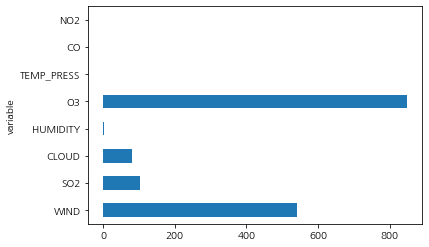

In [101]:
df_reg_coef.plot.barh(y="Coef", legend=False)

- 각각의 절대크기가 중요도를 말함
- O3가 높을수록 미세먼지 수치가 높음
- 바람이 셀수록 미세먼지 수치가 높음

In [109]:
# 표준화 회귀계수를 이용한 변수 중요도 확인

scaler=StandardScaler()
# 설명변수를 변환한다
cols=df_draw_x.columns

# scale 변환
np_scaled=scaler.fit_transform(df_draw_x)
df_scaled=pd.DataFrame(np_scaled, columns=cols)

In [110]:
# 목표변수 다시 추가
df_scaled['PM10']=original_data['PM10']

In [112]:
print(df_scaled)

           O3       NO2        CO       SO2      WIND  HUMIDITY     CLOUD  \
0    2.558984 -0.566824  0.001866 -0.052053  0.105769  0.204900  0.216196   
1    2.474806 -0.664322  0.001866 -0.052053  0.050401  0.204900 -0.410992   
2    1.548858 -0.371828 -0.679154 -0.052053 -0.600182  0.349878  0.414079   
3    0.875442 -0.079334 -0.679154 -0.052053 -0.254127 -0.112673 -0.843651   
4    1.801390  0.798148  0.001866 -0.052053 -1.070816 -1.017064 -0.380806   
..        ...       ...       ...       ...       ...       ...       ...   
360  1.296327 -1.054314 -0.679154 -0.052053  1.240829  1.640879  1.232442   
361  1.717213 -0.956816 -0.679154  1.531226 -0.406391  0.660547  0.387248   
362  1.717213 -1.736801 -0.679154 -0.052053  0.174980  0.764103 -0.813465   
363  0.202025  0.115662  0.682886 -0.052053  0.354929  1.054061  0.846738   
364  1.296327 -1.736801 -1.360174 -1.635332  2.458941  2.193179  1.658393   

     TEMP_PRESS  PM10  
0      1.035373  29.0  
1      1.061826  26.0  
2  

In [111]:
reg_model=smf.ols(formula= "PM10~O3+NO2+CO+WIND+SO2+HUMIDITY+CLOUD+TEMP_PRESS", data=df_scaled)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     38.51
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           6.81e-44
Time:                        01:05:50   Log-Likelihood:                -1409.1
No. Observations:                 364   AIC:                             2836.
Df Residuals:                     355   BIC:                             2871.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.5353      0.616     54.401      0.0

In [113]:
df_reg_coef=pd.DataFrame({'Coef': reg_result.params.values[1:]}, index=df_vif.variable[:8])

<AxesSubplot:ylabel='variable'>

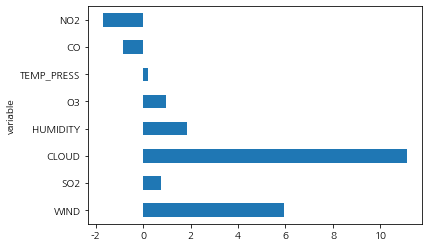

In [114]:
df_reg_coef.plot.barh(y="Coef", legend=False)

- 변수를 표준화해 중요도를 다시 확인한다.
- 몇몇 변수들의 중요도 크기가 변했다.
- CLOUD가 가장 중요한 변수로 순위권 안에 들었다.

# 의사결정나무

In [79]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
# 그래프에 음수나오도록
plt.rcParams["axes.unicode_minus"]=False

- PM10을 예측하는 의사결정나무 만들고 predict method로 예측값 구하기
- 목표변수 값의 평균을 예측하는 회귀 사용 예정

- 변수들 : O3	NO2	CO	SO2	TEMP	WIND	HUMIDITY	ATM_PRESS	CLOUD	SEASON	PRECIPITATION	CARDINAL_POINTS
- 목표변수: PM10

In [80]:
data=pd.read_csv("./AIR_POLLUTION.csv", parse_dates=['MeasDate'])
idx=data[data['PM10'].isnull()].index
print("PM10이 결측인 인덱스: {}\n확인 후 삭제".format(idx))
data=data.drop(idx)
data.fillna(0.4, inplace=True)

data['SEASON']=data['MeasDate'].apply(seasons)
data['PRECIPITATION']= ['YES' if (s > 0 or r> 0) else 'NO' for s, r in zip(data['SNOW'], data['RAIN'])]

data.drop('SNOW',axis=1, inplace =True)

data.drop('RAIN', axis=1, inplace=True)
data['CARDINAL_POINTS']=data['WIND_DIR'].apply(direction)
data.drop('WIND_DIR',axis=1, inplace =True)

PM10이 결측인 인덱스: Int64Index([328], dtype='int64')
확인 후 삭제


In [81]:
data_=data.drop('MeasDate', axis=1)


In [82]:
data_dummied=pd.get_dummies(data_, columns=['SEASON', 'PRECIPITATION', 'CARDINAL_POINTS'])

In [83]:
data_dummied

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,...,PRECIPITATION_NO,PRECIPITATION_YES,CARDINAL_POINTS_남남,CARDINAL_POINTS_남동,CARDINAL_POINTS_남서,CARDINAL_POINTS_동동,CARDINAL_POINTS_북동,CARDINAL_POINTS_북북,CARDINAL_POINTS_북서,CARDINAL_POINTS_서서
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,...,1,0,0,0,0,0,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,...,1,0,0,0,0,0,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,...,1,0,0,0,0,0,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,...,1,0,0,0,0,0,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,19.0,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73,...,0,1,0,0,1,0,0,0,0,0
362,22.0,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21,...,1,0,0,0,1,0,0,0,0,0
363,27.0,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63,...,1,0,0,0,0,0,0,0,0,1
364,36.0,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58,...,0,1,0,0,0,1,0,0,0,0


## 데이터구성

In [84]:

# 목표변수(PM10)와 설명변수(나머지 컬럼)을 분리하기
ty=data_dummied['PM10']
tx=data_dummied.drop('PM10', axis=1, inplace=False)
cols=tx.columns
np_scaled=scaler.fit_transform(tx)
tx=pd.DataFrame(np_scaled, columns=cols)
# 6:4 비율로 학습데이터와 테스트 데이터 분할
trainx, testx, trainy, testy=train_test_split(tx, ty, test_size=0.3, random_state=1234)
print('test data X size: {}'.format(testx.shape))
print('test data Y size: {}'.format(testy.shape))
print('train data for X size: {}'.format(trainx.shape))
print('train data for Y size: {}'.format(trainy.shape))

test data X size: (110, 23)
test data Y size: (110,)
train data for X size: (255, 23)
train data for Y size: (255,)


## 모델 생성(기본 옵션) 및 파라미터 조정

In [85]:
tree_uncustom=DecisionTreeRegressor(random_state=1234)
tree_uncustom.fit(trainx, trainy)
print("Score on training set: {}".format(tree_uncustom.score(trainx, trainy)))
print("Score on testing set: {}".format(tree_uncustom.score(testx, testy)))

Score on training set: 1.0
Score on testing set: 0.10006210088168077


- 테스트 데이터에 대해 너무 낮은 수치를 보여준다
- 튜닝을 통해 올려보도록 한다

In [86]:
# 모델파라미터 중 min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능
# 잎사귀노드의 수를 늘려가면서 트리를 생성하고 설명력을 기록한다
train_score=[]; test_score=[]
para_leaf=[n_leaf* 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(trainx, trainy)
    train_score.append(tree.score(trainx, trainy))
    test_score.append(tree.score(testx, testy))
    
df_score_leaf=pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score

In [87]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.100
1,2,0.936,0.143
2,3,0.851,0.282
3,4,0.805,0.361
4,5,0.757,0.391
5,6,0.730,0.400
6,7,0.696,0.440
7,8,0.668,0.419
8,9,0.651,0.438
9,10,0.642,0.427


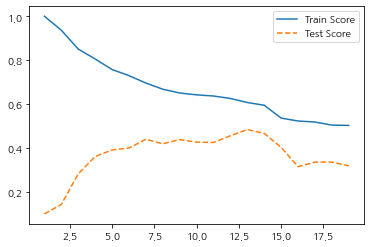

In [88]:
plt.plot(para_leaf, train_score, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_score, linestyle='--', label="Test Score")
plt.legend()

- leaf를 13으로 정하도록 한다. 

In [89]:
leaf=13

In [90]:
# 모델파라미터 중 min_samples_split: 분리노드의 최소 자료 수 변경에 따른 모델 성능
# 스플릿 수를 늘려가면서 트리를 생성하고 설명력을 기록한다
train_score=[]; test_score=[]
para_split=[n_split* 2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=leaf, min_samples_split=v_min_samples_split)
    tree.fit(trainx, trainy)
    train_score.append(tree.score(trainx, trainy))
    test_score.append(tree.score(testx, testy))
    
df_score=pd.DataFrame()
df_score['MinSamplesSplilt']=para_split
df_score['TrainScore']=train_score
df_score['TestScore']=test_score

In [91]:
df_score.round(3)

,MinSamplesSplilt,TrainScore,TestScore
0,2,0.607,0.484
1,4,0.607,0.484
2,6,0.607,0.484
3,8,0.607,0.484
4,10,0.607,0.484
5,12,0.607,0.484
6,14,0.607,0.484
7,16,0.607,0.484
8,18,0.607,0.484
9,20,0.607,0.484


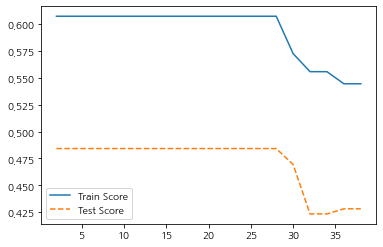

In [92]:
plt.plot(para_split, train_score, linestyle='-', label="Train Score")
plt.plot(para_split, test_score, linestyle='--', label="Test Score")
plt.legend()

- train score와 test score가 동일한 값을 갖는 split=6으로 정하도록 한다

In [93]:
split=6

In [94]:
# 모델파라미터 중 min_samples_depth: 트리의 깊이 변경에 따른 모델 성능
# 트리의 깊이를 늘려가며 생성하고 설명력을 기록한다
train_score=[]; test_score=[]
para_depth=[n_depth* 1 for n_depth in range(1,20)]

for max_depth in para_depth:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=leaf, max_depth=max_depth, min_samples_split=split)
    tree.fit(trainx, trainy)
    train_score.append(tree.score(trainx, trainy))
    test_score.append(tree.score(testx, testy))
    
df_score=pd.DataFrame()
df_score['MaxDepth']=para_depth
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score.round(3)

,MaxDepth,TrainScore,TestScore
0,1,0.257,0.221
1,2,0.355,0.311
2,3,0.471,0.393
3,4,0.556,0.470
4,5,0.607,0.484
5,6,0.607,0.484
6,7,0.607,0.484
7,8,0.607,0.484
8,9,0.607,0.484
9,10,0.607,0.484


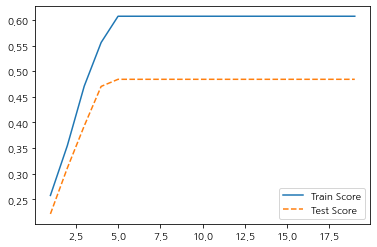

In [95]:
plt.plot(para_depth, train_score, linestyle='-', label="Train Score")
plt.plot(para_depth, test_score, linestyle='--', label="Test Score")
plt.legend()

- max_depth가 5 이상부터 더이상 스코어가 변하지 않으므로 9를 선택하도록 한다

In [96]:
depth=9

In [97]:
tree_final=DecisionTreeRegressor(random_state=1234, min_samples_leaf=leaf, max_depth=depth, min_samples_split=split)
tree_final.fit(trainx, trainy)
print("Score on training set: {}".format(tree_final.score(trainx, trainy)))
print("Score on testing set: {}".format(tree_final.score(testx, testy)))


Score on training set: 0.6072242949459141
Score on testing set: 0.48412549492468315


[Text(1585.2272727272727, 2768.3333333333335, 'CO <= -0.339\nmse = 249.787\nsamples = 255\nvalue = 33.282'),
 Text(986.3636363636364, 2265.0, 'CLOUD <= 1.023\nmse = 152.0\nsamples = 122\nvalue = 24.91'),
 Text(704.5454545454545, 1761.6666666666667, 'WIND <= 1.663\nmse = 148.128\nsamples = 94\nvalue = 27.691'),
 Text(563.6363636363636, 1258.3333333333335, 'O3 <= 0.833\nmse = 123.847\nsamples = 81\nvalue = 25.827'),
 Text(281.8181818181818, 755.0, 'WIND <= 0.133\nmse = 129.358\nsamples = 50\nvalue = 22.04'),
 Text(140.9090909090909, 251.66666666666697, 'mse = 42.266\nsamples = 25\nvalue = 18.12'),
 Text(422.72727272727275, 251.66666666666697, 'mse = 185.718\nsamples = 25\nvalue = 25.96'),
 Text(845.4545454545455, 755.0, 'HUMIDITY <= 0.36\nmse = 54.512\nsamples = 31\nvalue = 31.935'),
 Text(704.5454545454545, 251.66666666666697, 'mse = 34.052\nsamples = 18\nvalue = 28.944'),
 Text(986.3636363636364, 251.66666666666697, 'mse = 53.302\nsamples = 13\nvalue = 36.077'),
 Text(845.4545454545455

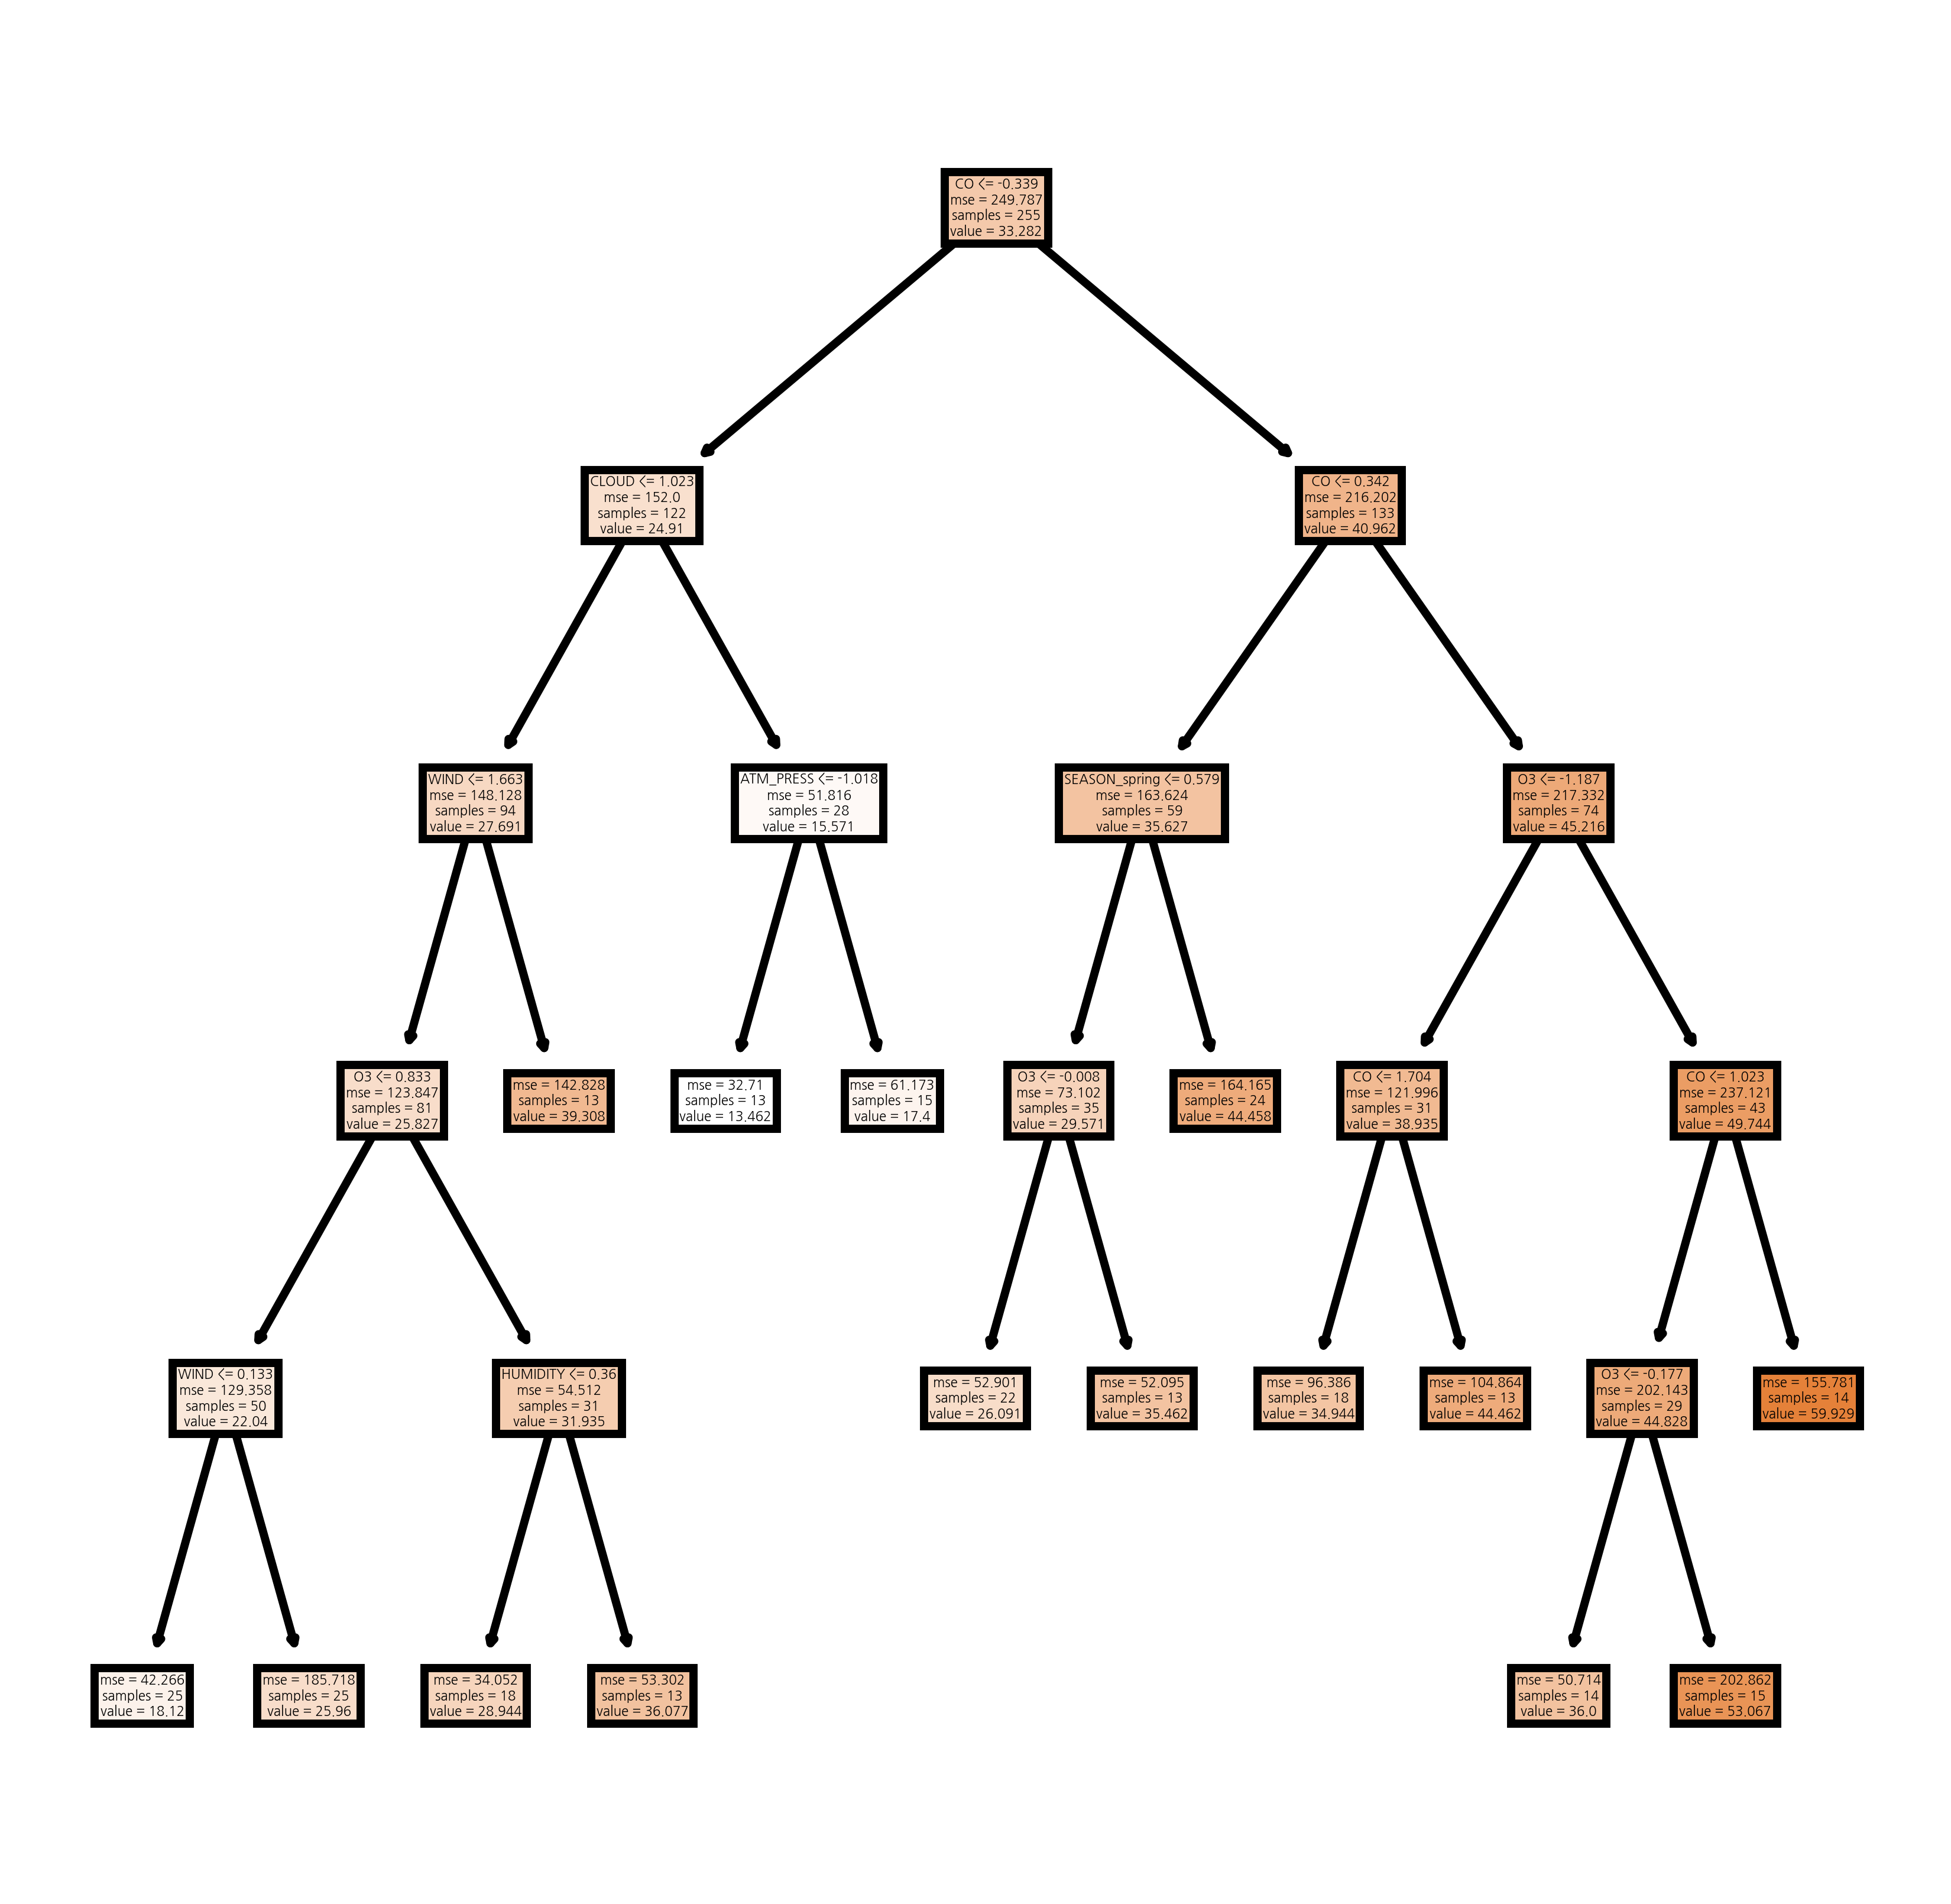

In [167]:
v_feature_name=trainx.columns
fig, axes=plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=1000)
plot_tree(tree_final, feature_names=v_feature_name, filled=True)

- 위 노드에서  cement가 조건을 만족하면 왼쪽으로, 만족하지 않으면 오른쪽으로 내려간다.
    > $mse= {\sum (y-\hat y)^2 \over n}$
- mse는 평균제곱오차로 노드가 아래로 갈수록 작아진다.
- samples는 해당 노드에 속하는 샘플의 숫자로 아래 두 개 샘플의 합이 위 샘플의 값이 된다.
- value는 해당 노드에 속하는 샘플들이 모두 이 value로 y값을 가지게 된다는 뜻이다.

## 중요도 확인
- 설명 변수의 중요도를 테이블과 그래프로 확인해본다.

In [169]:
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.575
0,O3,0.176
8,CLOUD,0.082
10,SEASON_spring,0.082
5,WIND,0.072
6,HUMIDITY,0.010
7,ATM_PRESS,0.003
15,CARDINAL_POINTS_남남,0.000
21,CARDINAL_POINTS_북서,0.000
20,CARDINAL_POINTS_북북,0.000


Text(0, 0.5, '변수')

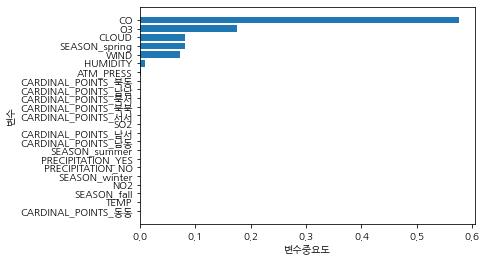

In [170]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수중요도")
plt.ylabel("변수")

## predict method
- 예측 데이터를 predict 해보도록 한다.

In [171]:
predicted_y=tree_final.predict(testx)

predicted=pd.DataFrame({'real.y': testy,'pred.y': predicted_y})
predicted

,real.y,pred.y
156,25.0,26.090909
310,28.0,18.120000
97,11.0,25.960000
134,37.0,44.461538
7,10.0,28.944444
...,...,...
31,15.0,18.120000
336,18.0,28.944444
345,40.0,17.400000
80,24.0,18.120000


In [172]:
# mse 구하기
mse=mean_squared_error(testy, predicted_y )
rmse=mse**0.5
print("mse: {}\nrmse: {}".format(mse, rmse))

mse: 134.8349294424113
rmse: 11.611844360066634


- mse값은 오류의 제곱이므로 실제 오류 평균보다 더 커지는 특성이 있어 루트를 씌운 RMSE값을 쓴다. 

- **모형에서 중요도 순서대로 나열한 변수들은 CO, O3, CLOUD...이다.**
    - **즉, CO, O3, CLOUD순으로 목표변수인 PM10(미세먼지 수치)에 영향을 준다.**
- 한국환경공단에 따르면, PM10은 사업장 연소, 자동차 연료 연소, 생물성 연소 과정등 특정 배출원으로부터 직접 발생한다고 한다. 
- 의사결정나무에서 주요 인자로 뽑힌 CO는 공장 가동시 나오는 연소 가스와 자동차 배기가스에서 주요하게 발생한다. 따라서 미세먼지를 줄이는 데 있어서 가장 중요한 정책으로 CO 배출량을 줄이는 것을 생각할 수 있다. 실제 UN 산하 기후기구 IPCC는 전반적인 탄소 배출량을 2010년 대비 45% 감축하는 것을 목표로 탄소중립경로를 제시했다 
- 흥미로운 것은 계절 중 파생변수 봄이 주요 인자 순위권 안에(4위) 들었다는 점이다. 봄철 주변 국가에서 오는 편서풍의 영향이 있지 않을까 추측할 수 있다. 
- 그 외 파생변수로 추가해준 풍향, 비/눈 여부 등은 미세먼지양을 추측하는데 크게 도움이 되지 않는다고 결론지을 수 있었다.

 # 랜덤포레스트
- PM10을 예측하는 랜덤포레스트 모델을 만들고 predict method로 예측값 구하기
- 변수들 : O3 NO2 CO SO2 TEMP WIND HUMIDITY ATM_PRESS CLOUD SEASON PRECIPITATION CARDINAL_POINTS
- 목표변수: PM10

## 데이터 구성

In [173]:
# 목표변수(PM10)와 설명변수(나머지 컬럼)을 분리하기
ty=data_dummied['PM10']
tx=data_dummied.drop('PM10', axis=1, inplace=False)
cols=tx.columns
np_scaled=scaler.fit_transform(tx)
tx=pd.DataFrame(np_scaled, columns=cols)
# 6:4 비율로 학습데이터와 테스트 데이터 분할
trainx, testx, trainy, testy=train_test_split(tx, ty, test_size=0.3, random_state=1234)
print('test data X size: {}'.format(testx.shape))
print('test data Y size: {}'.format(testy.shape))
print('train data for X size: {}'.format(trainx.shape))
print('train data for Y size: {}'.format(trainy.shape))

test data X size: (110, 23)
test data Y size: (110,)
train data for X size: (255, 23)
train data for Y size: (255,)


In [174]:
#### (2) 모델 생성(기본 옵션) 및 파라미터 조정
tree_uncustom=RandomForestRegressor(random_state=1234)
tree_uncustom.fit(trainx, trainy)
print("Score on training set: {}".format(tree_uncustom.score(trainx, trainy)))
print("Score on testing set: {}".format(tree_uncustom.score(testx, testy)))


Score on training set: 0.9215894557059192
Score on testing set: 0.4917804986789335


- 기본 옵션으로 랜덤포레스트 모델을 생성한다.
- 트레이닝 데이터에 대해 92%, 테스팅 데이터에 대해 49%의 예측율을 보였다. 과소적합이 심한 모습이다. 파라미터를 조절하여 스코어를 높이도록 하겠다

## 모델 파라미터 조절

In [175]:
# (1) 트리 수 변경에 따른 모델 성능
train_score=[]; test_score=[]
para_tree=[n_tree* 10 for n_tree in range(1,11)]

for v_n_estimator in para_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimator, random_state=1234)
    rf.fit(trainx, trainy)
    train_score.append(rf.score(trainx, trainy))
    test_score.append(rf.score(testx, testy))
    
df_score_tree=pd.DataFrame()
df_score_tree['n_estimators']=para_tree
df_score_tree['TrainScore']=train_score
df_score_tree['TestScore']=test_score
df_score_tree.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.890,0.453
1,20,0.900,0.502
2,30,0.907,0.509
3,40,0.909,0.508
4,50,0.915,0.495
5,60,0.919,0.497
6,70,0.922,0.494
7,80,0.922,0.500
8,90,0.921,0.497
9,100,0.922,0.492


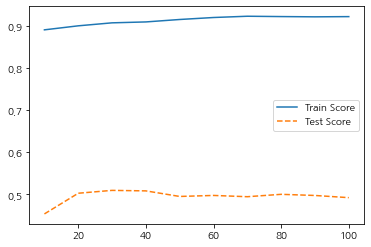

In [176]:
# 그래프로 확인
plt.plot(para_tree, train_score, linestyle='-', label="Train Score")
plt.plot(para_tree, test_score, linestyle='--', label="Test Score")
plt.legend()

- 트레인 데이터와 테스트 데이터에 가장 높은 예측율을 보이는 트리수 30을 선택한다

In [182]:
tree_number=30

In [183]:
# (2) 모델파라미터 중 min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능
# 잎사귀노드의 수를 늘려가면서 트리를 생성하고 설명력을 기록한다
train_score=[]; test_score=[]
para_leaf=[n_leaf* 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree=RandomForestRegressor(random_state=1234,n_estimators=tree_number, min_samples_leaf=v_min_samples_leaf)
    tree.fit(trainx, trainy)
    train_score.append(tree.score(trainx, trainy))
    test_score.append(tree.score(testx, testy))
    
df_score_leaf=pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.907,0.509
1,2,0.862,0.516
2,3,0.818,0.531
3,4,0.772,0.497
4,5,0.735,0.509
5,6,0.712,0.498
6,7,0.687,0.486
7,8,0.670,0.481
8,9,0.647,0.477
9,10,0.633,0.467


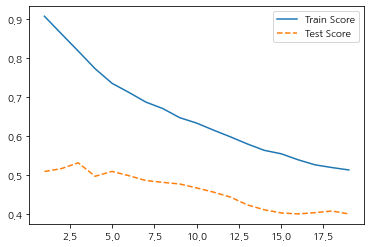

In [184]:
# 그래프로 확인한 모델 설명력
plt.plot(para_leaf, train_score, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_score, linestyle='--', label="Test Score")
plt.legend()

In [185]:
leaf=3

In [186]:
# (3) 분리 노드의 최소 자료 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_split=[n_split for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=v_min_samples_split)
                            
    rf.fit(trainx, trainy)
    train_score.append(rf.score(trainx, trainy))
    test_score.append(rf.score(testx, testy))

    
df_score_split=pd.DataFrame()
df_score_split['MinSamplesSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.818,0.531
1,3,0.818,0.531
2,4,0.818,0.531
3,5,0.818,0.531
4,6,0.818,0.531
5,7,0.807,0.529
6,8,0.797,0.523
7,9,0.786,0.521
8,10,0.775,0.512
9,11,0.763,0.509


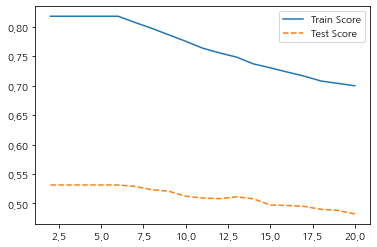

In [187]:
plt.plot(para_split, train_score, linestyle='-', label="Train Score")
plt.plot(para_split, test_score, linestyle='--', label="Test Score")
plt.legend()

- 분리 노드의 최소 자료수는 같은 값을 가지는 2~6 중 임의로 4를 선택하도록 한다.

In [188]:
split=4

In [189]:
# (4) 뎁스 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_depth=[n_depth for n_depth in range(1, 10)]

for v_min_samples_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split, max_depth=v_min_samples_depth)
                            
    rf.fit(trainx, trainy)
    train_score.append(rf.score(trainx, trainy))
    test_score.append(rf.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesDepth']=para_depth
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score.round(3)

,MinSamplesDepth,TrainScore,TestScore
0,1,0.289,0.279
1,2,0.439,0.362
2,3,0.570,0.453
3,4,0.663,0.487
4,5,0.739,0.509
5,6,0.781,0.522
6,7,0.803,0.525
7,8,0.812,0.528
8,9,0.816,0.528


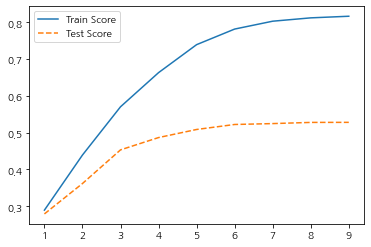

In [190]:

plt.plot(para_depth, train_score, linestyle='-', label="Train Score")
plt.plot(para_depth, test_score, linestyle='--', label="Test Score")
plt.legend()

- 최소 뎁스를 너무 크게 잡으면 리소스 자원을 과도하게 쓰기 때문에 적당히 타협하여 7을 선택하도록 한다

In [191]:
depth=7

In [193]:
tree_final=RandomForestRegressor(random_state=1234,n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split, max_depth=depth)
tree_final.fit(trainx, trainy)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(trainx, trainy)))
# testing 데이터 설명력
print("Score on testing set: {:.3f}".format(tree_final.score(testx, testy)))

Score on training set: 0.803
Score on testing set: 0.525


## 최종 모델 시각화
- 생성된 30개 트리 중 4번째 인덱스의 트리를 시각화해본다

[Text(1749.2857142857142, 2831.25, 'CO <= -0.339\nmse = 223.419\nsamples = 163\nvalue = 32.584'),
 Text(952.1428571428571, 2453.75, 'O3 <= 0.96\nmse = 139.927\nsamples = 78\nvalue = 24.3'),
 Text(664.2857142857142, 2076.25, 'CLOUD <= 0.917\nmse = 84.965\nsamples = 58\nvalue = 20.663'),
 Text(442.85714285714283, 1698.75, 'WIND <= 1.836\nmse = 77.947\nsamples = 39\nvalue = 23.982'),
 Text(354.2857142857143, 1321.25, 'SEASON_spring <= 0.579\nmse = 46.942\nsamples = 34\nvalue = 22.481'),
 Text(177.14285714285714, 943.75, 'WIND <= -0.822\nmse = 34.536\nsamples = 22\nvalue = 19.914'),
 Text(88.57142857142857, 566.25, 'mse = 120.667\nsamples = 3\nvalue = 29.0'),
 Text(265.7142857142857, 566.25, 'CLOUD <= -0.284\nmse = 17.996\nsamples = 19\nvalue = 19.062'),
 Text(177.14285714285714, 188.75, 'mse = 7.603\nsamples = 11\nvalue = 21.182'),
 Text(354.2857142857143, 188.75, 'mse = 9.24\nsamples = 8\nvalue = 14.4'),
 Text(531.4285714285714, 943.75, 'TEMP <= -0.37\nmse = 31.003\nsamples = 12\nvalue =

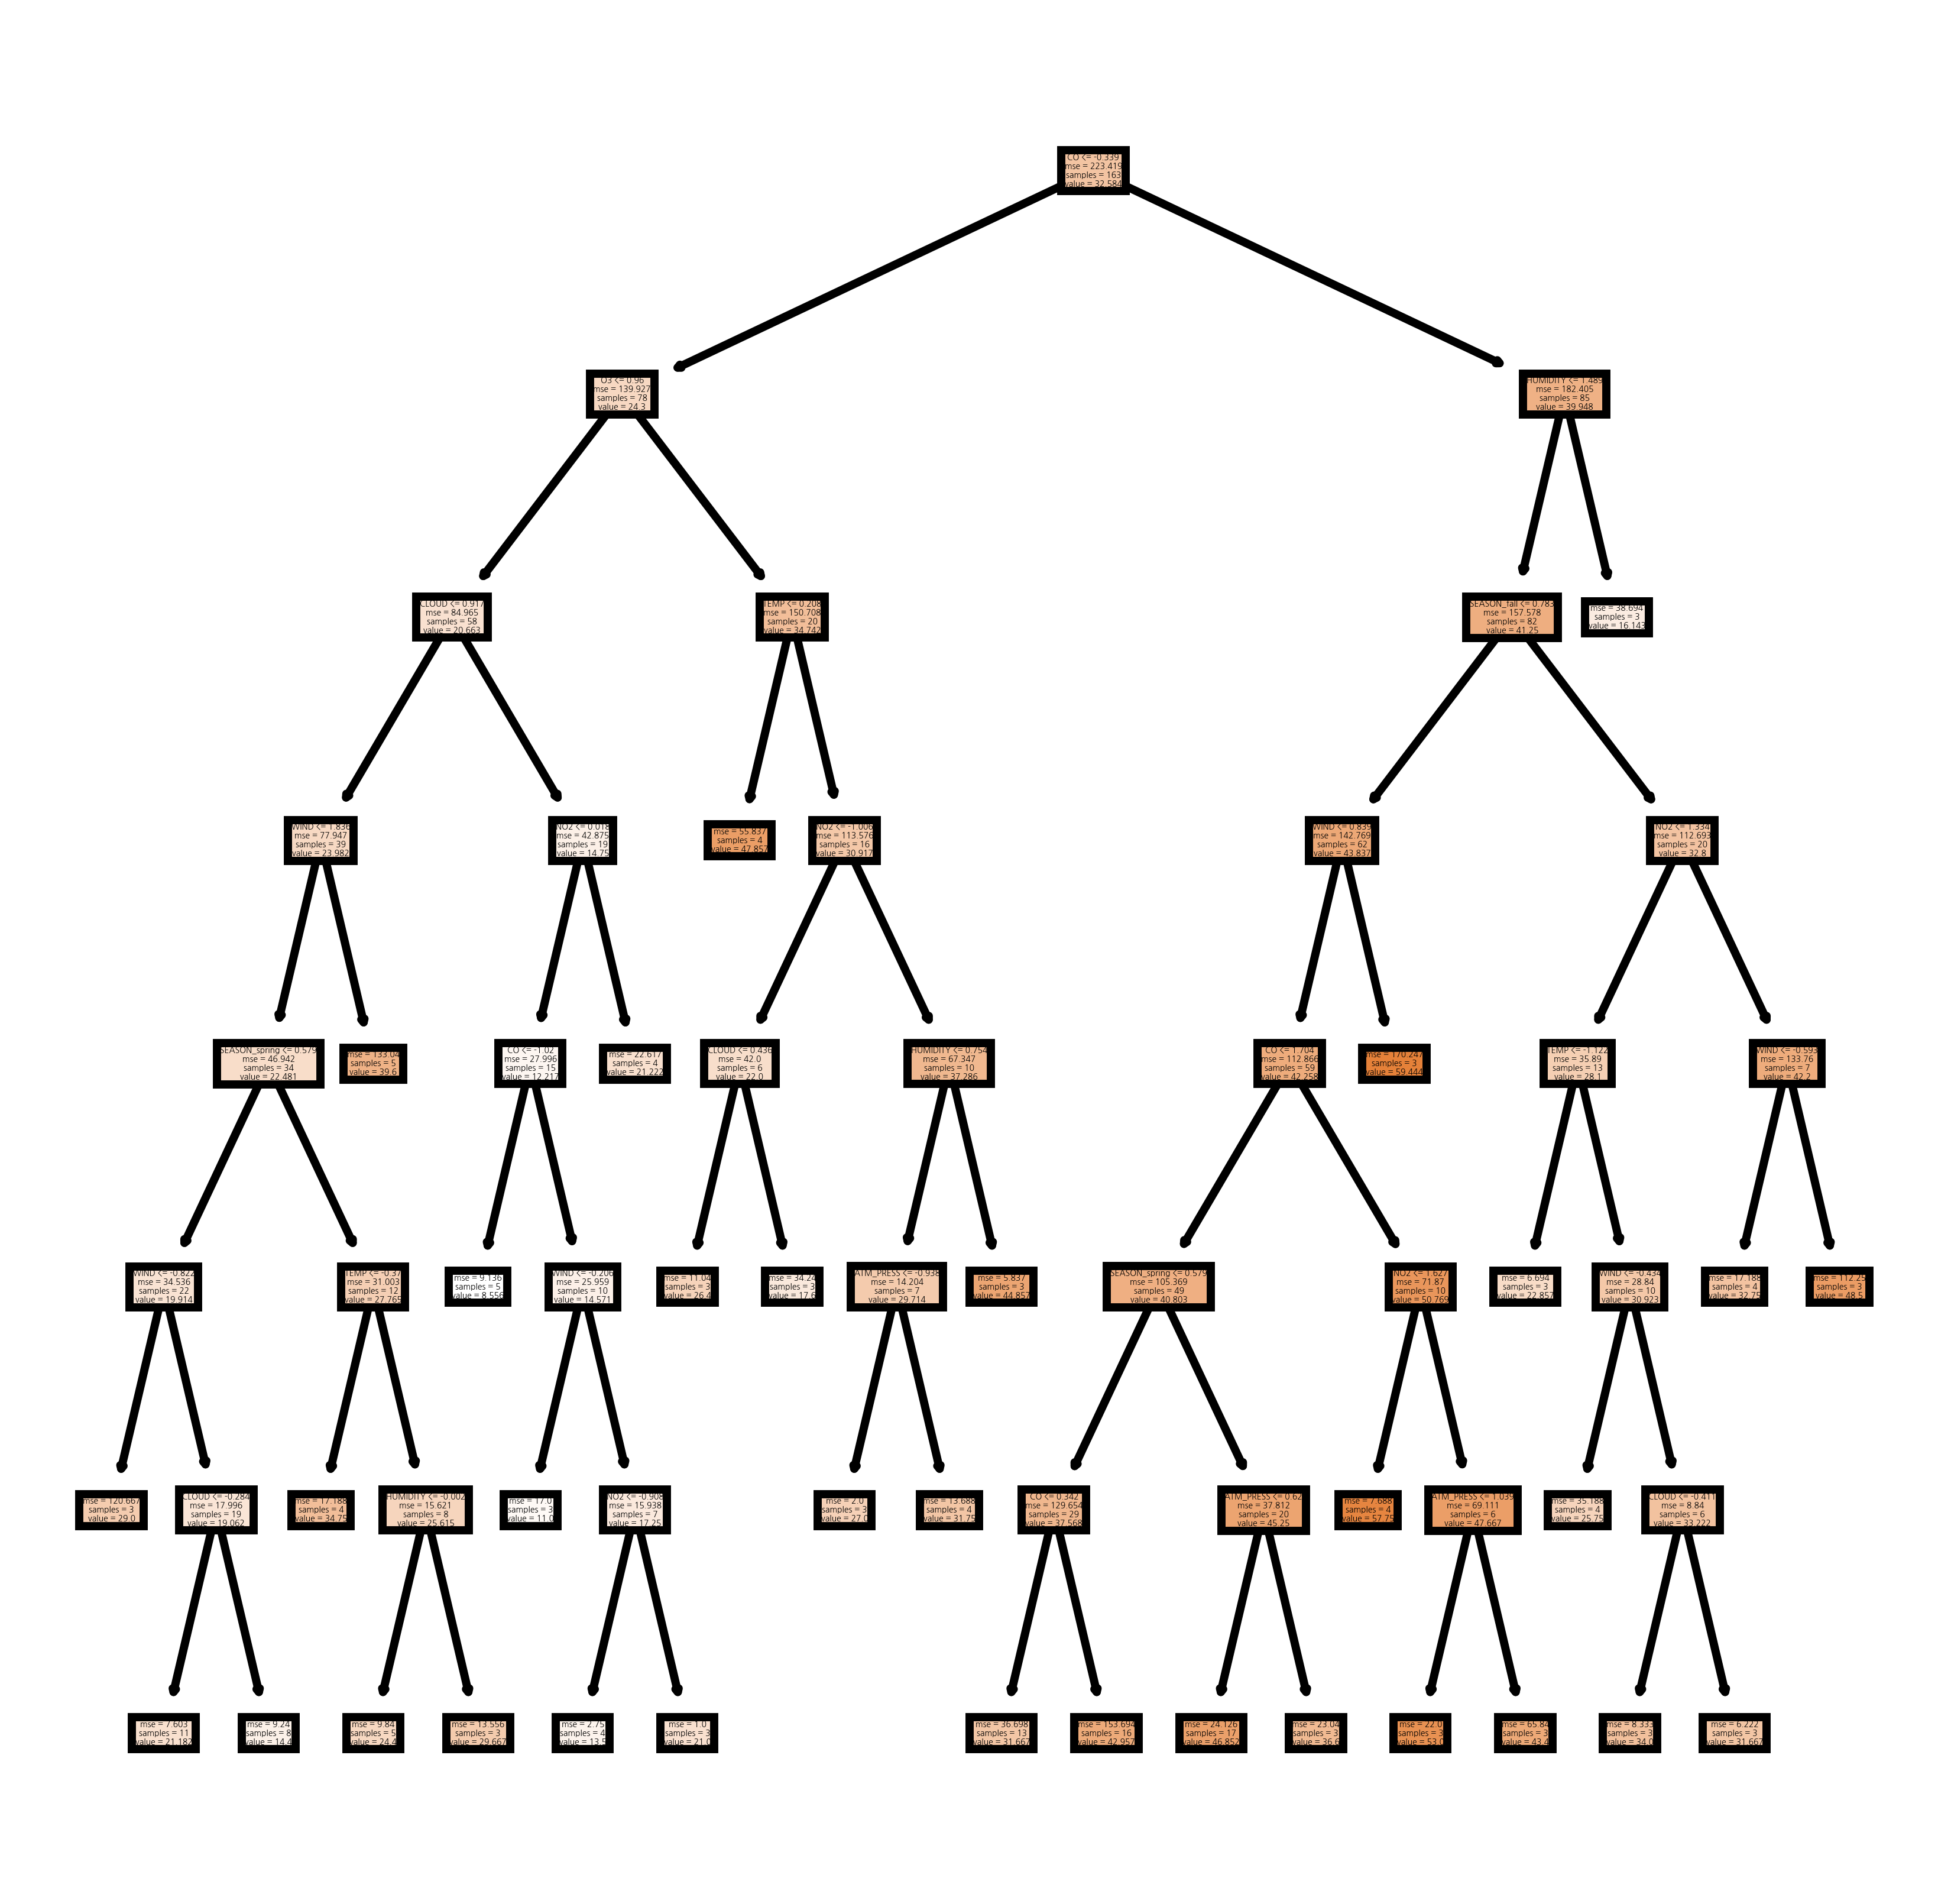

In [194]:
v_feature_name=trainx.columns
fig, axes=plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=1000)
plot_tree(tree_final.estimators_[4], feature_names=v_feature_name, filled=True)

## 중요도 확인
- 설명 변수의 중요도를 테이블과 그래프로 확인해본다.

In [195]:
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.estimators_[4].feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.397
6,HUMIDITY,0.110
5,WIND,0.107
0,O3,0.099
1,NO2,0.078
9,SEASON_fall,0.061
8,CLOUD,0.049
4,TEMP,0.046
10,SEASON_spring,0.039
7,ATM_PRESS,0.015


Text(0, 0.5, '변수')

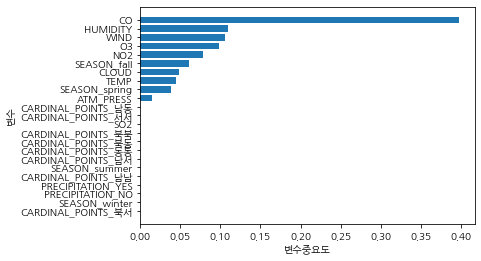

In [196]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수중요도")
plt.ylabel("변수")

- 해당 모델에서 변수중요도 분석 결과 CO, HUMIDITY, O3, NO2,...등이다.
    -  CO, HUMIDITY, O3, NO2,.순으로 목표변수인 PM10에 영향을 준다

## Predict Method
- 전체 30% 예측 데이터를 predict 해보도록 한다.

In [197]:
predicted_y=tree_final.predict(testx)

predicted=pd.DataFrame({'real.y': testy,'pred.y': predicted_y})
predicted

,real.y,pred.y
156,25.0,34.414093
310,28.0,26.469696
97,11.0,19.119720
134,37.0,44.941323
7,10.0,24.699750
...,...,...
31,15.0,18.179787
336,18.0,33.175054
345,40.0,19.716408
80,24.0,19.015517


- **실제 PM10(real.y)를 예측한 결과(pred.y)를 비교할 수 있다.**

In [198]:
# mse 구하기
mse=mean_squared_error(testy, predicted_y )
rmse=mse**0.5
print("mse: {}\nrmse: {}".format(mse, rmse))


#mse: 134.8349294424113
#rmse: 11.611844360066634

mse: 124.26956699255021
rmse: 11.147626069820884


- 랜덤포레스트 모델이 rmse가 더 작게 나왔다. 이는 의사결정모델보다 정확하게 예측 수행을 할 수 있었다는 뜻이다

# 그래디언트 부스팅
- PM10을 예측하는 그래디언트 부스팅 모델을 만들고 predict method를 이용하여 예측값을 구하기
- 그래디언트 부스팅은 잔여오차를 통해 다음 모델 구성 후 이전 모델과의 앙상블 결과로 모델을 생성

## 데이터 구성

In [200]:
# 목표변수(PM10)와 설명변수(나머지 컬럼)을 분리하기
ty=data_dummied['PM10']
tx=data_dummied.drop('PM10', axis=1, inplace=False)
cols=tx.columns
np_scaled=scaler.fit_transform(tx)
tx=pd.DataFrame(np_scaled, columns=cols)
# 6:4 비율로 학습데이터와 테스트 데이터 분할
trainx, testx, trainy, testy=train_test_split(tx, ty, test_size=0.3, random_state=1234)
print('test data X size: {}'.format(testx.shape))
print('test data Y size: {}'.format(testy.shape))
print('train data for X size: {}'.format(trainx.shape))
print('train data for Y size: {}'.format(trainy.shape))

test data X size: (110, 23)
test data Y size: (110,)
train data for X size: (255, 23)
train data for Y size: (255,)


## 모델 생성 및 파라미터 조정

In [259]:

tree_uncustom=GradientBoostingRegressor(random_state=1234)
tree_uncustom.fit(trainx, trainy)
print("Score on training set: {}".format(tree_uncustom.score(trainx, trainy)))
print("Score on testing set: {}".format(tree_uncustom.score(testx, testy)))


Score on training set: 0.9316516342656884
Score on testing set: 0.40155417711032526


In [260]:
# (1) 트리 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_tree:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesTree']=para_tree
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score

,MinSamplesTree,TrainScore,TestScore
0,10,0.517328,0.410083
1,20,0.676322,0.474737
2,30,0.758772,0.464673
3,40,0.807541,0.464568
4,50,0.846943,0.449702
5,60,0.874661,0.433627
6,70,0.895435,0.412728
7,80,0.908411,0.414956
8,90,0.922013,0.403674
9,100,0.931652,0.401554


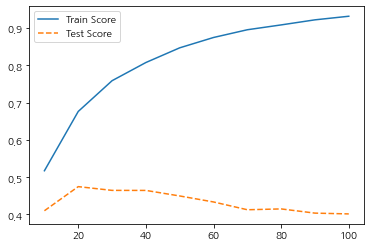

In [203]:

plt.plot(para_tree, train_score, linestyle='-', label="Train Score")
plt.plot(para_tree, test_score, linestyle='--', label="Test Score")
plt.legend()

- 적당한 스코어 차이를 보이고 트레인 데이터가 다소 높은 30을 선택한다

In [297]:
tree_number=30

In [298]:
# (2) 트리의 리프 노드의 최소 자료 수  변경에 따른 모델 성능
train_score=[]
test_score=[]
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_n_estimators in para_leaf:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesLeaf']=para_leaf
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.758772,0.464673
1,2,0.757835,0.476395
2,3,0.757651,0.484660
3,4,0.744515,0.494544
4,5,0.749360,0.476341
5,6,0.733125,0.486364
6,7,0.728426,0.494831
7,8,0.726860,0.495264
8,9,0.718845,0.475229
9,10,0.709027,0.479755


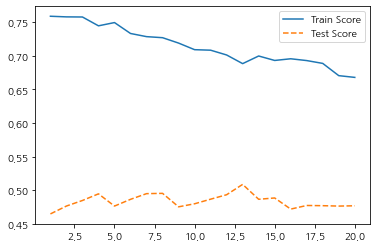

In [299]:

plt.plot(para_leaf, train_score, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_score, linestyle='--', label="Test Score")
plt.legend()

- 리프 노드의 자료 수 증가에 따라 모델의 설명력은 감소한다.
- 가장 높은 테스트 스코어를 가지는 13를 선택해주도록 한다

In [278]:
leaf=13

In [279]:
# (3) 트리 스플릿 자료 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_split=[n_split*2 for n_split in range(1, 31)]

for v_n_estimators in para_split:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesSplit']=para_split
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score.head(30)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.688266,0.508614
1,4,0.688266,0.508614
2,6,0.688266,0.508614
3,8,0.688266,0.508614
4,10,0.688266,0.508614
5,12,0.688266,0.508614
6,14,0.688266,0.508614
7,16,0.688266,0.508614
8,18,0.688266,0.508614
9,20,0.688266,0.508614


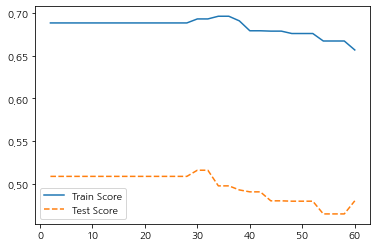

In [280]:
plt.plot(para_split, train_score, linestyle='-', label="Train Score")
plt.plot(para_split, test_score, linestyle='--', label="Test Score")
plt.legend()

- 최소 스플릿 수가 커질수록 스코어는 떨어지는 경향을 보인다
- 스코어 차이가 가장 작아지는 30을 선택한다

In [283]:
split=32

In [284]:
# (4) 뎁스수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_depth=[n_depth for n_depth in range(1, 21)]

for v_n_estimators in para_depth:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split,max_depth=v_n_estimators )
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamlesDepth']=para_depth
df_score['TrainScore']=train_score
df_score['TestScore']=test_score 
df_score

,MinSamlesDepth,TrainScore,TestScore
0,1,0.393785,0.360847
1,2,0.582512,0.476332
2,3,0.692953,0.515817
3,4,0.760575,0.477848
4,5,0.796877,0.469451
5,6,0.815092,0.484673
6,7,0.817236,0.494844
7,8,0.820098,0.489445
8,9,0.820404,0.488112
9,10,0.820404,0.488112


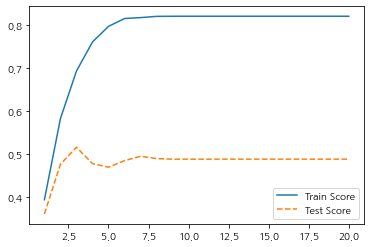

In [285]:
plt.plot(para_depth, train_score, linestyle='-', label="Train Score")
plt.plot(para_depth, test_score, linestyle='--', label="Test Score")
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가하지 않는 모습이다. 정체되어있는 score 중 일단 차이가 적은 3을 선택해본다

In [286]:
depth=3

In [287]:
# (5) 러닝레이트 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_n_estimators in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split, max_depth=depth, learning_rate=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['Learning Rate']=para_lr
df_score['TrainScore']=train_score
df_score['TestScore']=test_score 
df_score

,Learning Rate,TrainScore,TestScore
0,0.1,0.692953,0.515817
1,0.2,0.810757,0.471416
2,0.3,0.859123,0.432572
3,0.4,0.891809,0.437889
4,0.5,0.913696,0.421538
5,0.6,0.927719,0.403117
6,0.7,0.935522,0.391807
7,0.8,0.940976,0.375861
8,0.9,0.955407,0.328306


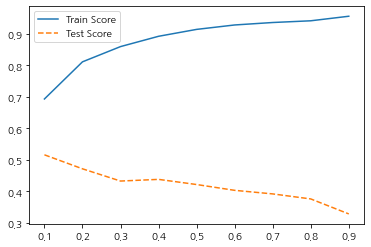

In [288]:
plt.plot(para_lr, train_score, linestyle='-', label="Train Score")
plt.plot(para_lr, test_score, linestyle='--', label="Test Score")
plt.legend()

- 0.1을 러닝레이트로 정하도록 한다. 스코어끼리 가장 차이가 적고 러닝레이트가 커질수록 테스트 스코어가 감소하는 경향을 볼 수 있다

## 최종 모델 생성

In [289]:
rate=0.1


gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split,max_depth=depth, learning_rate=rate)
gb_final.fit(trainx, trainy)
print('score on training set:{:.3f}'.format(gb_final.score(trainx, trainy)))
print('score on test set:{:.3f}'.format(gb_final.score(testx, testy)))

score on training set:0.693
score on test set:0.516


In [290]:
v_feature_name=trainx.columns

df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=gb_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.504
0,O3,0.173
10,SEASON_spring,0.071
8,CLOUD,0.053
4,TEMP,0.049
6,HUMIDITY,0.048
22,CARDINAL_POINTS_서서,0.027
5,WIND,0.024
7,ATM_PRESS,0.020
9,SEASON_fall,0.018


Text(0, 0.5, '변수')

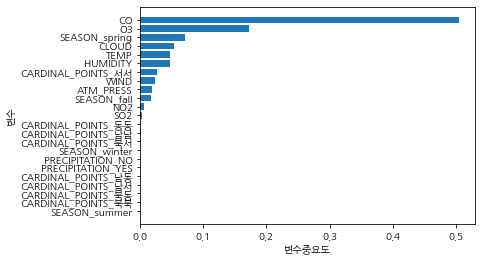

In [291]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수중요도")
plt.ylabel("변수")

- 그래디언트 부스팅 모델에서 중요도 순서대로 나열한 변수들은 CO, O3, 계절 중 봄, 기온, 습도 등이고 이 순서대로 목표변수인 PM10에 영향을 준다. 

## predict method

In [292]:
predicted_y=gb_final.predict(testx)

predicted=pd.DataFrame({'real.y': testy,'pred.y': predicted_y})
predicted

,real.y,pred.y
156,25.0,28.711303
310,28.0,25.843585
97,11.0,18.940256
134,37.0,44.232049
7,10.0,22.982459
...,...,...
31,15.0,19.015073
336,18.0,26.079152
345,40.0,19.071231
80,24.0,21.817121


In [293]:
# mse 구하기
mse=mean_squared_error(testy, predicted_y )
rmse=mse**0.5
print("mse: {}\nrmse: {}".format(mse, rmse))

# mse: 124.26956699255021
# rmse: 11.147626069820884

mse: 126.55163463391095
rmse: 11.249517084475713


- 직전에 수행했던 랜덤포레스트 모델이 그래디언트 부스팅보다 높은 rmse를 보여준다. 
- 파라미터 선택에 보다 신중해야 함을 경험했다

## 의사결정나무, 랜덤포레스트와 그래디언트 부스팅에서 순위권에 든 주요 변수를 뽑아 모델을 만들어보자.

In [352]:
# 의사결정나무

# Feature	Importance
# 2	CO	0.575
# 0	O3	0.176
# 8	CLOUD	0.082
# 10	SEASON_spring	0.082
# 5	WIND	0.07
# 랜덤포레스트
# 2	CO	0.397
# 6	HUMIDITY	0.110
# 5	WIND	0.107
# 0	O3	0.099
# 1	NO2	0.078
# 그래디언트
# 2	CO	0.504
# 0	O3	0.173
# 10	SEASON_spring	0.071
# 8	CLOUD	0.053
# 4	TEMP	0.049
# 6	HUMIDITY	0.048
# 22	CARDINAL_POINTS_서서	0.027

# CO, O3, SEASON_spring, HUMIDITY, WIND, CLOUD
# 목표변수()와 설명변수(나머지 컬럼)을 분리하기
print(data)
ty=data_dummied['PM10']
tx=data_dummied[['CO', 'O3', 'SEASON_spring', 'HUMIDITY']]
# 7:3 비율 학습데이터와 테스트 데이터 분할
trainx, testx, trainy, testy=train_test_split(tx, ty, test_size=0.3, random_state=1234)
print('test data X size: {}'.format(testx.shape))
print('test data Y size: {}'.format(testy.shape))
print('train data for X size: {}'.format(trainx.shape))
print('train data for Y size: {}'.format(trainy.shape))

      MeasDate  PM10     O3    NO2   CO    SO2   TEMP  WIND  HUMIDITY  \
0   2019-07-01  29.0  0.054  0.021  0.5  0.003  24.03  2.30      63.2   
1   2019-07-02  26.0  0.053  0.020  0.5  0.003  24.29  2.26      63.2   
2   2019-07-03  30.0  0.042  0.023  0.4  0.003  24.18  1.79      65.3   
3   2019-07-04  28.0  0.034  0.026  0.4  0.003  25.35  2.04      58.6   
4   2019-07-05  29.0  0.045  0.035  0.5  0.003  27.30  1.45      45.5   
..         ...   ...    ...    ...  ...    ...    ...   ...       ...   
361 2020-06-26  19.0  0.039  0.016  0.4  0.003  21.66  3.12      84.0   
362 2020-06-27  22.0  0.044  0.017  0.4  0.004  23.94  1.93      69.8   
363 2020-06-28  27.0  0.044  0.009  0.4  0.003  25.03  2.35      71.3   
364 2020-06-29  36.0  0.026  0.028  0.6  0.003  24.06  2.48      75.5   
365 2020-06-30   6.0  0.039  0.009  0.3  0.002  20.60  4.00      92.0   

     ATM_PRESS  CLOUD  SEASON PRECIPITATION CARDINAL_POINTS  
0        995.1   5.70  summer            NO              서서  

In [353]:
# 그래디언트 부스팅으로 진행

tree_uncustom=GradientBoostingRegressor(random_state=1234)
tree_uncustom.fit(trainx, trainy)
print("Score on training set: {}".format(tree_uncustom.score(trainx, trainy)))
print("Score on testing set: {}".format(tree_uncustom.score(testx, testy)))


Score on training set: 0.8569023262949779
Score on testing set: 0.4428110895267776


In [354]:
# (1) 트리 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_tree:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesTree']=para_tree
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score

,MinSamplesTree,TrainScore,TestScore
0,10,0.478784,0.395856
1,20,0.620505,0.495368
2,30,0.687178,0.499778
3,40,0.736009,0.488250
4,50,0.768839,0.479186
5,60,0.786634,0.484996
6,70,0.808415,0.478734
7,80,0.818885,0.480913
8,90,0.833941,0.460141
9,100,0.856902,0.442811


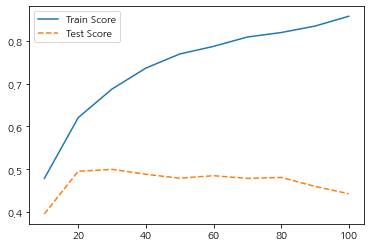

In [355]:

plt.plot(para_tree, train_score, linestyle='-', label="Train Score")
plt.plot(para_tree, test_score, linestyle='--', label="Test Score")
plt.legend()

- tree_number=30

In [356]:
tree_number=30

In [357]:
# (2) 트리의 리프 노드의 최ㅗ 자료 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_n_estimators in para_leaf:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesLeaf']=para_leaf
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.687178,0.499778
1,2,0.687295,0.502894
2,3,0.690090,0.479460
3,4,0.679291,0.468455
4,5,0.667425,0.462368
5,6,0.675814,0.483605
6,7,0.668866,0.485379
7,8,0.660808,0.484377
8,9,0.659167,0.469642
9,10,0.650143,0.485271


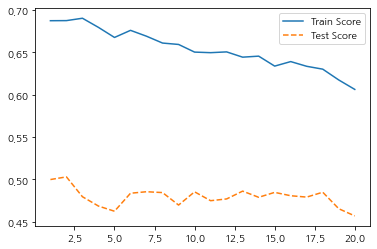

In [358]:

plt.plot(para_leaf, train_score, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_score, linestyle='--', label="Test Score")
plt.legend()

In [359]:
leaf=2

In [360]:
# (3) 트리 스플릿 자료 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_split=[n_split*2 for n_split in range(1, 21)]

for v_n_estimators in para_split:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamplesSplit']=para_split
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
df_score.head(30)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.687295,0.502894
1,4,0.687295,0.502894
2,6,0.688445,0.503976
3,8,0.688262,0.505144
4,10,0.683727,0.501202
5,12,0.682505,0.500408
6,14,0.682359,0.500207
7,16,0.676331,0.486539
8,18,0.675657,0.487477
9,20,0.665952,0.482832


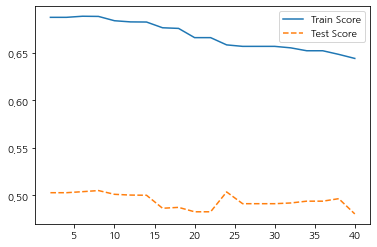

In [361]:
plt.plot(para_split, train_score, linestyle='-', label="Train Score")
plt.plot(para_split, test_score, linestyle='--', label="Test Score")
plt.legend()

In [362]:
split=24

In [363]:
# (4) 뎁스수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_depth=[n_depth for n_depth in range(1, 21)]

for v_n_estimators in para_depth:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split, max_depth=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['MinSamlesDepth']=para_depth
df_score['TrainScore']=train_score
df_score['TestScore']=test_score 
df_score

,MinSamlesDepth,TrainScore,TestScore
0,1,0.383708,0.364280
1,2,0.555998,0.456203
2,3,0.658329,0.503693
3,4,0.736703,0.475676
4,5,0.823853,0.341906
5,6,0.847638,0.276040
6,7,0.864468,0.240912
7,8,0.868405,0.235329
8,9,0.876018,0.221859
9,10,0.879173,0.223916


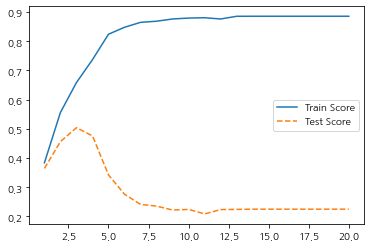

In [364]:
plt.plot(para_depth, train_score, linestyle='-', label="Train Score")
plt.plot(para_depth, test_score, linestyle='--', label="Test Score")
plt.legend()

In [365]:
depth=3

In [366]:
# (5) 러닝레이트 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_n_estimators in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split, max_depth=depth, learning_rate=v_n_estimators)
                            
    gb.fit(trainx, trainy)
    train_score.append(gb.score(trainx, trainy))
    test_score.append(gb.score(testx, testy))

    
df_score=pd.DataFrame()
df_score['Learning Rate']=para_lr
df_score['TrainScore']=train_score
df_score['TestScore']=test_score 
df_score

,Learning Rate,TrainScore,TestScore
0,0.1,0.658329,0.503693
1,0.2,0.736761,0.473927
2,0.3,0.768424,0.441351
3,0.4,0.816944,0.386548
4,0.5,0.836148,0.390776
5,0.6,0.831194,0.426481
6,0.7,0.874915,0.127038
7,0.8,0.878023,-0.004716
8,0.9,0.869628,0.188515


In [368]:
gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=split,max_depth=depth, learning_rate=0.1)
gb_final.fit(trainx, trainy)
print('score on training set:{:.3f}'.format(gb_final.score(trainx, trainy)))
print('score on test set:{:.3f}'.format(gb_final.score(testx, testy)))

score on training set:0.658
score on test set:0.504


In [369]:
predicted_y=gb_final.predict(testx)

predicted=pd.DataFrame({'real.y': testy,'pred.y': predicted_y})
predicted

,real.y,pred.y
156,25.0,27.944974
310,28.0,31.428684
97,11.0,18.451782
134,37.0,46.073856
7,10.0,27.086320
...,...,...
31,15.0,16.229131
336,18.0,23.130534
345,40.0,27.495474
80,24.0,24.084823


In [370]:
# mse 구하기
mse=mean_squared_error(testy, predicted_y )
rmse=mse**0.5
print("mse: {}\nrmse: {}".format(mse, rmse))

# mse: 124.26956699255021
# rmse: 11.147626069820884

mse: 129.72050002882955
rmse: 11.389490771269344


## 결론
- 의사결정나무, 랜덤포레스트, 그래디언트 부스팅의 예측 모델을 각각 만들어보았다.
- mse가 낮은 순서대로 랜덤포레스트, 그래디언트 부스팅, 의사결정나무 순이었다.
- 의사결정나무는 주어진 데이터셋과 달리 분류 이산형 예측에 더 좋은 성능을 보인다고 한다.
- 그래디언트 부스팅은 랜덤 포레스트보다 매개변수 설정에 좀 더 민감하지만 잘 조정만 한다면 높은 정확도를 보여준다.하지만 해당 데이터셋에는 랜덤포레스트가 더 높은 정확도를 보여줬다. -> 하이퍼 파라미터 조작에 미숙한 분석가의 탓이라고 생각함.
- 임의로 만든 파생변수들 대부분은 0.0의 주요도를 보였다. 경험이 주는 인사이트로 이런 시행착오를 줄여 자원을 효과적으로 쓸 수 있을 것으로 사료됨.|

# 추가) Xgboost 

- 그래디언트 부스팅을 병렬학습할 수 있도록 구현 
- 캐글 대회에서 5년 연속 1위 알고리즘

In [60]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
scaler=StandardScaler()
# 목표변수(PM10)와 설명변수(나머지 컬럼)을 분리하기
ty=data_dummied['PM10']
tx=data_dummied.drop('PM10', axis=1, inplace=False)
cols=tx.columns
np_scaled=scaler.fit_transform(tx)
tx=pd.DataFrame(np_scaled, columns=cols)
# 6:4 비율로 학습데이터와 테스트 데이터 분할
trainx, testx, trainy, testy=train_test_split(tx, ty, test_size=0.3, random_state=1234)
print('test data X size: {}'.format(testx.shape))
print('test data Y size: {}'.format(testy.shape))
print('train data for X size: {}'.format(trainx.shape))
print('train data for Y size: {}'.format(trainy.shape))

test data X size: (110, 23)
test data Y size: (110,)
train data for X size: (255, 23)
train data for Y size: (255,)


In [61]:
tx=tx.to_numpy()
ty=ty.to_numpy()

ty.mean()

In [63]:
y=np.log(ty) # 로그를 통해 정규화
y.mean()

3.3907714901066686

In [64]:
X_df=pd.DataFrame(tx, columns=cols)
X_df

,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,SEASON_fall,...,PRECIPITATION_NO,PRECIPITATION_YES,CARDINAL_POINTS_남남,CARDINAL_POINTS_남동,CARDINAL_POINTS_남서,CARDINAL_POINTS_동동,CARDINAL_POINTS_북동,CARDINAL_POINTS_북북,CARDINAL_POINTS_북서,CARDINAL_POINTS_서서
0,2.558984,-0.566824,0.001866,-0.052053,1.035373,0.105769,0.204900,-1.325967,0.216196,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,1.605749
1,2.474806,-0.664322,0.001866,-0.052053,1.061826,0.050401,0.204900,-0.894922,-0.410992,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,1.605749
2,1.548858,-0.371828,-0.679154,-0.052053,1.050634,-0.600182,0.349878,-0.931868,0.414079,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,1.605749
3,0.875442,-0.079334,-0.679154,-0.052053,1.169676,-0.254127,-0.112673,-1.141233,-0.843651,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,1.605749
4,1.801390,0.798148,0.001866,-0.052053,1.368080,-1.070816,-1.017064,-1.523017,-0.380806,-0.487122,...,0.678233,-0.678233,2.148345,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,-0.622762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1.296327,-1.054314,-0.679154,-0.052053,0.794236,1.240829,1.640879,-1.215127,1.232442,-0.487122,...,-1.474420,1.474420,-0.465475,-0.330791,1.933975,-0.355729,-0.167836,-0.091035,-0.304655,-0.622762
361,1.717213,-0.956816,-0.679154,1.531226,1.026215,-0.406391,0.660547,-1.239758,0.387248,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,1.933975,-0.355729,-0.167836,-0.091035,-0.304655,-0.622762
362,1.717213,-1.736801,-0.679154,-0.052053,1.137118,0.174980,0.764103,-1.375230,-0.813465,-0.487122,...,0.678233,-0.678233,-0.465475,-0.330791,-0.517070,-0.355729,-0.167836,-0.091035,-0.304655,1.605749
363,0.202025,0.115662,0.682886,-0.052053,1.038425,0.354929,1.054061,-1.596910,0.846738,-0.487122,...,-1.474420,1.474420,-0.465475,-0.330791,-0.517070,2.811128,-0.167836,-0.091035,-0.304655,-0.622762


In [65]:
x_train, x_test, y_train, y_test = train_test_split(X_df, y)

In [66]:
x_train.shape #  (15480, 8)
type(x_train) # DataFrame
y_train.shape # (15480,)
type(y_train) # numpy.ndarray

numpy.ndarray

In [67]:
model = XGBRegressor(n_estimators=400) # 트리의 개수 400개로 모델 생성
model.fit(x_train, y_train)
model
# objective='reg:linear'

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

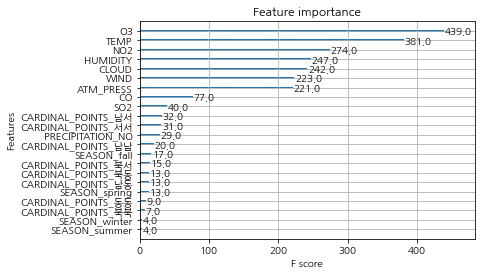

In [68]:
plot_importance(model)

In [77]:
r_sq=model.score(x_test, y_test)

In [99]:
# 정확도
print("예측 정확도: {}".format(r_sq))

예측 정확도: 0.6319302362357561


In [73]:
y_pred = model.predict(x_test)
y_true = y_test

mse = mean_squared_error(y_true, y_pred) 
print(mse)
mse # 0.099451
rmse=mse**0.5


0.09945189953875991


In [72]:
print(rmse)

0.3153599523382129


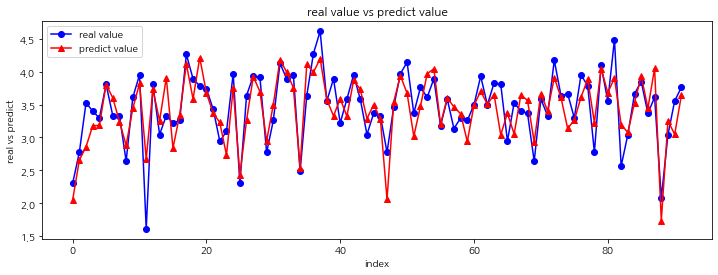

In [71]:
fig = plt.figure( figsize = (12, 4) )
chart = fig.add_subplot(1,1,1)
chart.plot(y_true[:100], marker='o', color='blue', label='real value')
chart.plot(y_pred[:100], marker='^', color='red', label='predict value')
chart.set_title('real value vs predict value')
plt.xlabel('index')
plt.ylabel('real vs predict')
plt.legend(loc = 'best') 